In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors

In [3]:
#name of the saved plaque segmentation mask
plaqueMaskName='PlaqueMask6'
plaqueMaskImg='Maskofplaque6.tif'
lossThreshSize=1111 #predicted size larger than this number is considered a positive classification
hiddendim=5000 #joint latent space dimension
trainClusters=[3] #the graph autoencoder cluster(s) used for training the regression model


In [4]:
#load joint latent embedding - These are the same parameters as in the training notebooks.

datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}


scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')

gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.1epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)
gaeclusterlabels=gaeclusterlabels.astype(int)
    
sampleNames=None
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    if sampleNames is None:
        sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
    else:
        sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)

cellCoord={}
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    cidx=np.repeat(False,np.sum(scaleddata.obs['sample']==sampleidx_s))
    for c in trainClusters:
        cidx=np.logical_or(gaeclusterlabels[sampleNames==s]==c,cidx)
    cellCoord[s]=(((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())/0.3).astype(int))[cidx]
    
scaleddata=None

# cellCoord={}
# for s in sampleidx.keys():
#     sampleidx_s=sampleidx[s] 
#     cellCoord[s]=((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())/0.3).astype(int)
# scaleddata=None


os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

use_cuda=True
fastmode=False #Validate during training pass
seed=3
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*25*25
fc_dim2=5000
# fc_dim3=128
# fc_dim4=128

model_str='cnn_vae'
targetBatch=None
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.5)
plotepoch=36
name='cd13_thresh25_02'
modelsavepath='/mnt/external_ssd/xinyi/models/train_jointGAEcnn_starmap/'+name

#Load data
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

# Create model
if model_str=='cnn_vae':
    model = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
if model_str=='cnn_vae_alexnet':
    model = modelsCNN.CNN_VAE_alexnet(fc_dim1)
    
if use_cuda:
    model.cuda()    
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(plotepoch)+'.pt')))

#compute embeddings
mulist={}
labellist={}
with torch.no_grad():
    model.eval()
    for s in plot_samples.keys():
        training_samples_t=s
        if 'disease' in s:
            plaqueMaskImg_s=plaqueMaskImg
        elif 'control' in s:
            plaqueMaskImg_s=None
        imgInputnp,labellist[s]=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,cellCoord[training_samples_t],sampleidx[training_samples_t],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
        muplot_all=np.zeros((imgInputnp.shape[0],hiddendim))
        for i in range(imgInputnp.shape[0]):
            imgInput=imgInputnp[[i]]
            if use_cuda:
                imgInput=torch.tensor(imgInput).cuda().float()
            recon,z, mu, logvar = model(imgInput)

            mu=mu.cpu().detach().numpy()
    #             if plotRecon:
    #                 if plotRecon=='meanRecon':
    #                     mu=features_recon[3].cpu().detach().numpy()
            muplot_all[i]=mu
        mulist[s]=muplot_all
        imgInputnp=None

(22210, 22344)
(22355, 18953)
(22294, 19552)
(22452, 19616)


In [5]:
# Settings of the regression model
name='cd13regrsJoint_thresh25min12_overlap70area70_03_cluster01'
fastmode=False #Validate during training pass
seed=3
epochs=1250 #number of training epochs
saveFreq=10 #frequencies to save the intermediate model parameters
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=128 #size of training batch

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
model_str='fc_regrs3' #name of the regression model as defined below

#standard CNN parameters
kernel_size=4
stride=2
padding=1

fc_dim1=1024 #hidden dimensions of the regression model
fc_dim2=1024
fc_dim3=1024
# fc_dim4=1024
# fc_dim5=1024

# training_samples=['control13','disease13','disease8','control8']
training_samples=['disease13','control13']
switchFreq=1
logsavepath='/mnt/external_ssd/xinyi/log/train_regrsFromJoint_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_regrsFromJoint_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_regrsFromJoint_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/mnt/xinyi/2021-01-13-mAD-test-dataset'

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True



In [6]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [8]:
diamThresh_mul=800 
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7

s=training_samples[0]
allInputnp=mulist[s].astype('float32')
allLabelsnp=labellist[s].astype('float32')
allSampleNames=np.repeat(s,mulist[s].shape[0])
#all_thresh25min12_overlap70area70_04_shuffled only
# trainInputnp=trainInputnp.astype('float32')
# valInputnp=valInputnp.astype('float32')
for sidx in range(1,len(training_samples)):
    s=training_samples[sidx]
    allInputnp=np.concatenate((allInputnp,mulist[s].astype('float32')),axis=0)
    allLabelsnp=np.concatenate((allLabelsnp,labellist[s]),axis=0)
    allSampleNames=np.concatenate((allSampleNames,np.repeat(s,mulist[s].shape[0])),axis=0)

num_test=int(round(testNodes*allInputnp.shape[0]))
num_val=int(round(valNodes*allInputnp.shape[0]))
sampleidx=np.arange(allInputnp.shape[0])
np.random.shuffle(sampleidx)
alltestIdx=sampleidx[:num_test]
allvalIdx=sampleidx[num_test:(num_val + num_test)]
alltrainIdx=sampleidx[(num_val + num_test):]


In [9]:
npos=0
nneg=0
npos=np.sum(allLabelsnp!=0)
nneg=allLabelsnp.shape[0]-npos
print(npos)
print(nneg)
negweight=(nneg+npos)/nneg
posweight=(nneg+npos)/npos

485
1572


In [10]:
# mse=torch.nn.MSELoss(reduction=None)
# Create model
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    
if model_str=='fc_regrs3':
    model = modelsCNN.FC_l3(allInputnp.shape[1],fc_dim1,fc_dim2,fc_dim3,1,0.5,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')
if model_str=='fc_regrs5':
    model = modelsCNN.FC_l5(allInputnp.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,1,0.5,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')
if model_str=='fc_regrs1':
    model = modelsCNN.FC_l1(allInputnp.shape[1],fc_dim1,1,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')
if model_str=='fc_regrs0':
    model = modelsCNN.FC_l0(allInputnp.shape[1],1,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')


# if model_str=='cnnvae_clf':
#     model = modelsCNN.CNN_VAE_clf(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     lossCE=torch.nn.CrossEntropyLoss(torch.tensor([1,imageslist['disease13'][3].shape[0]/np.sum(imageslist['disease13'][3])]).cuda().float())

if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [10]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(3990)+'.pt')))
# epochs=5000

    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    loss_binary_all=0
    loss_binary_all_pos=0
    loss_binary_all_neg=0
    for i in range(int(np.ceil(alltrainIdx.shape[0]/batchsize))):
        trainIdx=alltrainIdx[i*batchsize:min((i+1)*batchsize,allInputnp.shape[0])]
        
        trainInput=allInputnp[trainIdx]
        labels=allLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(trainInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        optimizer.zero_grad()

        pred = model(trainInput)
        
        #binary classification loss 
        loss_binary_all+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))*posweight
        loss_binary_all+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))*negweight
        loss_binary_all_pos+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))
        loss_binary_all_neg+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))

        if 'regrs' in model_str:
            weight_curr=torch.where(labels==0,torch.Tensor([negweight]).cuda(),torch.Tensor([posweight]).cuda())
            loss=torch.mean(lossCE(pred.flatten(),labels)*weight_curr)
            loss_all+=loss.item()
        else:
            loss=lossCE(pred,labels)
            loss_all+=loss.item()
        if i==0:
            print(pred.flatten()[:10])
            print(labels[:10])
        loss.backward()
        optimizer.step()

#     print(pred.flatten())
#     print(labels)
    loss_all=loss_all/int(np.ceil(alltrainIdx.shape[0]/batchsize))
    loss_binary_all=loss_binary_all/alltrainIdx.shape[0]/2
    loss_binary_all_pos=loss_binary_all_pos/np.sum(allLabelsnp[alltrainIdx]>0)
    loss_binary_all_neg=loss_binary_all_neg/np.sum(allLabelsnp[alltrainIdx]==0)
    
    model.eval()
    loss_val_all=0
    loss_val_binary_all=0
    loss_val_binary_all_pos=0
    loss_val_binary_all_neg=0
    for i in range(int(np.ceil(allvalIdx.shape[0]/batchsize))):
        valIdx=allvalIdx[i*batchsize:min((i+1)*batchsize,allInputnp.shape[0])]
        valInput=allInputnp[valIdx]
        labels=allLabelsnp[valIdx]
        if use_cuda:
            valInput=torch.tensor(valInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        pred = model(valInput)

        loss_val_binary_all+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))*posweight
        loss_val_binary_all+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))*negweight
        loss_val_binary_all_pos+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))
        loss_val_binary_all_neg+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))
        
        if 'regrs' in model_str:
            weight_curr=torch.where(labels==0,torch.Tensor([negweight]).cuda(),torch.Tensor([posweight]).cuda())
            loss_val_all+=torch.mean(lossCE(pred.flatten(),labels)*weight_curr).item()
        else:
            loss_val_all+=lossCE(pred,labels).item()
        if i==0:
            print(pred.flatten()[:10])
            print(labels[:10])
        
#     print(pred.flatten())
#     print(labels)
    loss_val_all=loss_val_all/int(np.ceil(allvalIdx.shape[0]/batchsize))
    loss_val_binary_all=loss_val_binary_all/allvalIdx.shape[0]/2
    loss_val_binary_all_pos=loss_val_binary_all_pos/np.sum(allLabelsnp[allvalIdx]>0)
    loss_val_binary_all_neg=loss_val_binary_all_neg/np.sum(allLabelsnp[allvalIdx]==0)
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_train_clf: {:.4f}'.format(loss_binary_all),
          'loss_val: {:.4f}'.format(loss_val_all),
         'loss_val_clf: {:.4f}'.format(loss_val_binary_all))
    return loss_all,loss_val_all,loss_binary_all,loss_binary_all_pos,loss_binary_all_neg,loss_val_binary_all,loss_val_binary_all_pos,loss_val_binary_all_neg
    
train_loss_ep=[None]*epochs
val_loss_ep=[None]*epochs
train_lossclf_ep=[None]*epochs
train_lossclfPos_ep=[None]*epochs
train_lossclfNeg_ep=[None]*epochs
val_lossclf_ep=[None]*epochs
val_lossclfPos_ep=[None]*epochs
val_lossclfNeg_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    
    train_loss_ep[ep],val_loss_ep[ep],train_lossclf_ep[ep],train_lossclfPos_ep[ep],train_lossclfNeg_ep[ep],val_lossclf_ep[ep],val_lossclfPos_ep[ep],val_lossclfNeg_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


tensor([0.0000, 0.0000, 0.0000, 0.0061, 0.0000, 0.0000, 0.0000, 0.0015, 0.0000,
        0.0000], device='cuda:0', grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([0.0211, 0.0208, 0.0222, 0.0209, 0.0196, 0.0225, 0.0218, 0.0212, 0.0225,
        0.0198], device='cuda:0', grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0000 loss_train: 467892660.5714 loss_train_clf: 0.4804 loss_val: 1064421056.0000 loss_val_clf: 0.7206
tensor([0.0219, 0.0258, 0.0221, 0.0268, 0.0228, 0.0192, 0.0107, 0.0212, 0.0206,
        0.0132], device='cuda:0', grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([0.0439, 0.0443, 0.0473, 0.0429, 0.0410, 0.0473, 0.0461, 0.0446, 0.0482,
        0.0420], device='cuda:0', grad_fn=<SliceBack

tensor([ 9.7984,  9.9592, 11.7063,  8.6299,  8.3435, 11.3065, 10.8017,  9.7780,
        12.2676,  9.1066], device='cuda:0', grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0015 loss_train: 467615061.7143 loss_train_clf: 0.4804 loss_val: 1063832768.0000 loss_val_clf: 0.7206
tensor([ 7.4975,  8.3533,  9.7518, 13.0691,  7.1405, 11.4201,  7.2976,  7.6608,
         7.1261, 10.3052], device='cuda:0', grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([12.8780, 13.0871, 15.3963, 11.3380, 10.9615, 14.8690, 14.1956, 12.8484,
        16.1310, 11.9693], device='cuda:0', grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0016 loss_train: 467525222.8571 loss_train_clf: 0.4804 loss_val: 1063647552.0000 loss_val_clf: 

       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([168.2466, 170.7514, 201.7964, 147.8911, 143.0274, 194.7462, 185.2537,
        167.7601, 211.1503, 156.5320], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0030 loss_train: 462777837.7143 loss_train_clf: 0.4804 loss_val: 1054346752.0000 loss_val_clf: 0.7206
tensor([125.7141, 150.7873, 158.4965, 213.4708, 127.3631, 170.0556, 120.0628,
        134.9652, 136.7098, 183.1609], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([191.1057, 193.9456, 229.2362, 167.9786, 162.4583, 221.2297, 210.4176,
        190.5588, 239.8508, 177.8088], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,    

            0.], device='cuda:0')
tensor([710.9285, 721.2325, 853.2041, 624.7238, 604.0229, 823.3074, 782.2825,
        708.8054, 892.3235, 661.5949], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0044 loss_train: 446328681.1429 loss_train_clf: 0.4804 loss_val: 1022679936.0000 loss_val_clf: 0.7206
tensor([583.3725, 645.6110, 736.7833, 913.8008, 577.6482, 643.9576, 496.1730,
        559.2935, 565.1148, 883.7114], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([770.7591, 781.9142, 925.0155, 677.2903, 654.8170, 892.5840, 848.0824,
        768.4423, 967.4039, 717.2698], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0045 loss_

tensor([1752.1035, 1777.0757, 2102.8535, 1539.3080, 1487.0439, 2029.0520,
        1927.1057, 1746.4541, 2198.5784, 1630.0691], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0057 loss_train: 417475476.5714 loss_train_clf: 0.4586 loss_val: 965533632.0000 loss_val_clf: 0.3875
tensor([1472.1876, 1595.6790, 1747.2498, 2249.4236, 1241.3092, 1791.1631,
        1366.6970, 1436.0234, 1356.0542, 1626.6146], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([1855.8049, 1882.2274, 2227.2991, 1630.4004, 1574.8818, 2149.1528,
        2041.0992, 1849.7650, 2328.6333, 1726.4978], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0058 loss_train

tensor([3328.7483, 3375.2546, 3994.4802, 2923.9561, 2820.0308, 3854.6428,
        3659.5024, 3316.5564, 4174.6641, 3094.8228], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0070 loss_train: 381009178.2857 loss_train_clf: 0.5060 loss_val: 888020224.0000 loss_val_clf: 0.4319
tensor([2833.8521, 3200.9666, 3106.8391, 3958.9448, 2434.1504, 3198.6545,
        2600.4326, 2655.5488, 2274.5144, 3291.3518], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([3466.0833, 3514.4309, 4159.2285, 3044.5908, 2935.8508, 4013.6492,
        3810.3560, 3453.2778, 4346.6948, 3222.2646], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0071 loss_train

tensor([5020.3140, 5088.7656, 6022.3022, 4409.7275, 4241.6855, 5812.6807,
        5515.8657, 4999.4971, 6290.9092, 4662.6646], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0082 loss_train: 352571977.1429 loss_train_clf: 0.5060 loss_val: 816910400.0000 loss_val_clf: 0.4319
tensor([4002.4116, 4773.5835, 5166.6274, 6802.4922, 3549.6987, 5401.6904,
        3623.2114, 4384.5659, 4418.5806, 5361.3823], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([5159.1211, 5229.2666, 6188.5889, 4531.6514, 4357.7588, 5973.3623,
        5668.0659, 5137.5156, 6464.3115, 4791.0664], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0083 loss_train

tensor([6627.0439, 6712.9961, 7945.4326, 5821.7129, 5575.8540, 7673.2690,
        7274.7402, 6596.5127, 8293.9775, 6145.6738], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0095 loss_train: 334922285.7143 loss_train_clf: 0.5060 loss_val: 760834176.0000 loss_val_clf: 0.4319
tensor([5199.7300, 6281.2251, 6359.5786, 8133.8389, 4657.4722, 6559.0498,
        5010.6953, 5401.6401, 5009.9038, 7432.2832], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([6729.2998, 6816.0933, 8067.5879, 5911.6240, 5659.7900, 7791.7627,
        7386.3687, 6698.0381, 8420.9873, 6239.7026], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0096 loss_train

            0.], device='cuda:0')
Epoch: 0107 loss_train: 329457161.1429 loss_train_clf: 0.5060 loss_val: 732100736.0000 loss_val_clf: 0.4319
tensor([5975.2358, 6307.5386, 7543.5615, 9846.0674, 5549.5903, 7101.3774,
        5462.7173, 6305.2334, 6000.2002, 7964.6636], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([7660.2275, 7751.6055, 9177.5654, 6731.1006, 6411.3906, 8872.3740,
        8398.7529, 7622.6577, 9571.7949, 7091.4058], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0108 loss_train: 329652077.7143 loss_train_clf: 0.5060 loss_val: 730558272.0000 loss_val_clf: 0.4319
tensor([6281.6714, 6657.6836, 7252.0371, 9231.6064, 6067.6089, 7583.5483,
        5101.0635, 6366.0288, 5948.4092, 8713.3672], device='cuda:0',
       grad_fn=<SliceBackw

tensor([ 6596.8491,  6885.4878,  7770.5093, 11025.7051,  6339.2583,  8230.5723,
         6092.0229,  6721.3154,  6409.4170,  9040.0645], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8162.6724,  8249.5283,  9771.8730,  7175.0698,  6792.6211,  9459.7461,
         8937.0850,  8122.2783, 10181.5195,  7543.3032], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0121 loss_train: 326288192.0000 loss_train_clf: 0.5060 loss_val: 717324928.0000 loss_val_clf: 0.4319
tensor([7323.5215, 7090.3213, 8287.4805, 9720.9004, 5824.0811, 7844.7188,
        5917.6050, 6463.8179, 6274.4023, 8318.1475], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
te

            0.], device='cuda:0')
Epoch: 0134 loss_train: 326338195.4286 loss_train_clf: 0.5060 loss_val: 711773888.0000 loss_val_clf: 0.4319
tensor([ 6990.7910,  7116.1782,  8016.0615, 10413.9072,  5623.2124,  8236.3838,
         5749.9395,  6913.6206,  5658.7017,  8348.1523], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8390.0703,  8466.5264, 10034.9150,  7377.4326,  6937.8125,  9731.1162,
         9171.0586,  8349.3223, 10444.5576,  7739.2339], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0135 loss_train: 326461828.5714 loss_train_clf: 0.5060 loss_val: 711496384.0000 loss_val_clf: 0.4319
tensor([ 7060.4102,  7658.2012,  8226.3643, 11958.4014,  6377.3530,  8309.8018,
         6677.4482,  6339.3271,  7277.5645,  8893.0186], device='cuda:

tensor([ 7091.4517,  6886.4097,  8516.1934, 11340.3330,  6115.9639,  8386.6787,
         6375.9434,  6850.5308,  6671.7686,  8677.9326], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8479.8984,  8545.6943, 10134.7783,  7458.6040,  6974.6182,  9842.4629,
         9255.9971,  8439.9395, 10539.0332,  7810.0771], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0147 loss_train: 326084214.8571 loss_train_clf: 0.5060 loss_val: 709104768.0000 loss_val_clf: 0.4319
tensor([ 6908.5469,  7866.9814,  8935.8779, 10108.8867,  6174.3823,  8301.0371,
         6051.5664,  6768.2124,  6690.3496,  9091.5361], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 6878.7373,  7228.9731,  8571.1729, 11545.1748,  6056.7202,  8051.4082,
         5796.0469,  6256.3369,  6483.3853,  8949.8818], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8537.2979,  8590.9717, 10195.0723,  7511.5679,  6981.7905,  9917.3389,
         9304.2666,  8498.5537, 10591.7529,  7850.3984], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0160 loss_train: 325383718.8571 loss_train_clf: 0.5060 loss_val: 707474880.0000 loss_val_clf: 0.4319
tensor([ 7554.0020,  7688.2222,  8049.6235, 11648.3174,  6502.6445,  7378.1650,
         5961.6787,  6493.4897,  7565.9268,  8352.9883], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 8566.0986,  8607.4033, 10221.2988,  7539.3213,  6965.7773,  9959.3320,
         9321.3389,  8528.8721, 10608.9590,  7864.6875], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0173 loss_train: 325252804.5714 loss_train_clf: 0.5060 loss_val: 706516288.0000 loss_val_clf: 0.4319
tensor([ 7420.9893,  7389.1538,  7803.8389, 11963.2314,  6523.0210,  9190.1826,
         5894.5098,  7201.9023,  7091.2021,  7946.8120], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8568.1797,  8608.5459, 10223.1172,  7541.3110,  6964.4160,  9962.4248,
         9322.4590,  8531.0381, 10610.0820,  7865.6621], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 6820.0586,  6876.9111,  7611.7769, 10562.0967,  6694.2354,  8953.9658,
         6052.6235,  7035.2617,  7071.9038,  8933.2686], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8585.0020,  8613.8008, 10235.3975,  7558.0225,  6941.8047,  9990.0244,
         9327.3594,  8549.0088, 10613.9160,  7870.0811], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0186 loss_train: 324652201.1429 loss_train_clf: 0.5060 loss_val: 705794240.0000 loss_val_clf: 0.4319
tensor([ 7399.7261,  7091.9595,  8581.4307, 10814.4619,  6310.0688,  9031.9619,
         6307.4258,  6652.5088,  6579.6396,  8436.8232], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 8607.9932,  8625.2402, 10255.3916,  7580.7129,  6924.7124, 10024.9023,
         9339.3828,  8573.7598, 10625.5742,  7880.3286], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0198 loss_train: 323679177.1429 loss_train_clf: 0.5060 loss_val: 704993344.0000 loss_val_clf: 0.4319
tensor([ 6556.8013,  7193.8340,  8383.4502, 11747.3691,  7132.8008,  8993.6094,
         5821.1719,  6809.2930,  7171.3657,  8499.2266], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8610.7422,  8627.0791, 10258.1260,  7583.3716,  6924.0161, 10028.8516,
         9341.2891,  8576.7031, 10627.6230,  7881.9878], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 6588.7627,  7587.4702,  8910.8027, 10904.5156,  6446.4561,  8713.2139,
         6098.4546,  6973.1304,  6126.8721,  8975.4121], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8630.8262,  8635.3105, 10274.6758,  7603.1274,  6904.3105, 10060.3418,
         9349.8604,  8598.3164, 10635.3164,  7889.5073], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0211 loss_train: 322601950.8571 loss_train_clf: 0.5060 loss_val: 704174144.0000 loss_val_clf: 0.4319
tensor([ 6794.0356,  7223.8345,  8239.2148, 10690.5469,  6078.8296,  8379.8936,
         6372.1816,  6966.4751,  6991.5278,  8482.7344], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 8655.1689,  8647.8926, 10296.2627,  7626.5205,  6887.8833, 10096.8408,
         9363.1592,  8624.3203, 10648.2959,  7900.7290], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0223 loss_train: 321346358.8571 loss_train_clf: 0.5060 loss_val: 703344576.0000 loss_val_clf: 0.4319
tensor([ 7508.4600,  7601.4497,  9305.0488, 11671.9131,  6495.3604,  8839.8428,
         6823.6699,  6635.5303,  6728.2051,  8403.0576], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8656.9131,  8648.6455, 10297.7129,  7628.2920,  6886.2480, 10099.5547,
         9363.9355,  8626.1934, 10648.9980,  7901.4502], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 7143.3247,  7277.1274,  8250.3906, 11404.1152,  6302.9741,  9080.1299,
         5783.1631,  7520.4800,  6700.7510,  9260.5381], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8678.5811,  8658.2129, 10315.8018,  7649.6216,  6867.0483, 10132.9463,
         9373.9336,  8649.4707, 10658.4170,  7910.2544], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0236 loss_train: 322848189.7143 loss_train_clf: 0.5060 loss_val: 702512128.0000 loss_val_clf: 0.4319
tensor([ 7594.4692,  7462.1035,  8389.3486, 11353.8037,  6696.8975,  9908.1250,
         6277.0073,  7885.3306,  6920.2617,  9017.1084], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 8688.4287,  8655.4961, 10319.7227,  7660.0801,  6838.0620, 10152.3945,
         9370.8984,  8661.0703, 10652.9570,  7907.8730], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0248 loss_train: 321945769.1429 loss_train_clf: 0.5060 loss_val: 702020224.0000 loss_val_clf: 0.4319
tensor([ 6687.2856,  7588.5601,  8939.8877, 10527.6650,  6032.8955,  9814.4971,
         6443.1094,  6953.7915,  6935.3350,  8733.1992], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8690.4209,  8656.4932, 10321.5215,  7662.0078,  6836.6377, 10155.4316,
         9371.9395,  8663.2256, 10654.0264,  7908.7876], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 7427.1060,  7403.7246,  7992.5615, 11302.4375,  6241.9248,  8452.5723,
         6396.5444,  6706.9976,  6279.4131,  8861.6943], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8720.4736,  8673.9912, 10349.4092,  7690.7075,  6823.4604, 10198.7686,
         9390.5742,  8694.9238, 10673.1533,  7925.0474], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0261 loss_train: 321456635.4286 loss_train_clf: 0.5060 loss_val: 700983616.0000 loss_val_clf: 0.4319
tensor([ 7304.6787,  7332.9194,  8573.3242, 11125.1572,  7045.0415,  9114.0654,
         6102.1953,  7226.0728,  7004.9062,  9346.9531], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 6902.8096,  7451.0200,  7883.1743, 11255.5381,  7293.8779,  9176.9014,
         6199.7354,  6782.7437,  7406.0845,  7944.0205], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8740.9209,  8680.6943, 10364.9834,  7710.7271,  6798.7725, 10231.4619,
         9397.2383,  8717.6377, 10678.6113,  7931.2339], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0274 loss_train: 320479288.0000 loss_train_clf: 0.5060 loss_val: 700212736.0000 loss_val_clf: 0.4319
tensor([ 6520.8271,  7019.6470,  9061.4805, 10685.3955,  6870.0029,  9042.1709,
         5927.7681,  7109.5791,  6376.1021,  8410.5811], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 8756.9541,  8683.8965, 10376.0400,  7726.8276,  6773.5190, 10258.7744,
         9400.3994,  8736.0459, 10680.3916,  7934.5352], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0286 loss_train: 319525659.4286 loss_train_clf: 0.5060 loss_val: 699558016.0000 loss_val_clf: 0.4319
tensor([ 7601.2949,  7062.0425,  8169.1211, 10142.3047,  6750.7329,  8850.4473,
         6126.3589,  7487.1499,  6825.3955,  9647.5322], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8757.5029,  8683.3184, 10375.9814,  7727.4756,  6770.7461, 10260.1113,
         9399.7803,  8736.7842, 10679.5234,  7934.0522], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 8781.0986,  8692.5625, 10395.5977,  7750.7607,  6747.4570, 10297.0898,
         9409.6729,  8762.9541, 10688.6064,  7942.8765], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0300 loss_train: 318586419.4286 loss_train_clf: 0.5060 loss_val: 698668096.0000 loss_val_clf: 0.4319
tensor([ 7242.8667,  7644.3032,  8745.6123, 10207.6748,  6845.9204, 10235.7285,
         5977.4600,  7063.3184,  6156.5811,  9088.7344], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8782.1592,  8692.4932, 10396.1611,  7751.8877,  6745.0288, 10299.0303,
         9409.5342,  8764.2090, 10688.3154,  7942.8496], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 8801.5322,  8698.0771, 10410.6699,  7770.6157,  6720.5347, 10330.3213,
         9415.2217,  8785.9326, 10692.8203,  7948.1118], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0313 loss_train: 318842798.8571 loss_train_clf: 0.5060 loss_val: 697887808.0000 loss_val_clf: 0.4319
tensor([ 7176.6675,  6710.6548,  8065.9150, 11567.8535,  6192.1963,  9030.2510,
         6437.2192,  6664.0596,  7119.4824,  8649.7744], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8804.0664,  8699.4814, 10413.0098,  7773.0645,  6719.2090, 10334.0586,
         9416.7061,  8788.7188, 10694.3965,  7949.4194], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8826.8037,  8708.5000, 10431.7021,  7795.1807,  6696.6738, 10369.7344,
         9425.9902,  8814.4307, 10703.2510,  7957.8550], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0326 loss_train: 317383965.7143 loss_train_clf: 0.5060 loss_val: 696982528.0000 loss_val_clf: 0.4319
tensor([ 7790.5938,  7390.9390,  8109.2773, 12394.7383,  6009.1777,  9157.2402,
         5698.8765,  7020.2134,  7180.5972,  8339.2676], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8828.7705,  8709.2363, 10433.2998,  7797.0078,  6694.7920, 10372.6611,
         9426.7627,  8816.6074, 10703.9619,  7958.5244], device='c

tensor([ 7854.2588,  7056.7329,  8324.7695, 11763.8926,  5901.5498,  9106.2295,
         5993.1792,  7084.0435,  6676.4624,  8253.1436], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8844.2734,  8710.4443, 10443.2207,  7812.8867,  6665.7939, 10399.6689,
         9427.7852,  8835.1592, 10703.3320,  7959.9990], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0339 loss_train: 316990747.4286 loss_train_clf: 0.5060 loss_val: 696251840.0000 loss_val_clf: 0.4319
tensor([ 7522.1499,  7381.8799,  9152.4111, 10956.4229,  7174.3096,  9027.2666,
         5852.9751,  7000.5996,  7885.5112,  9152.9258], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8871.2559,  8722.6973, 10466.4229,  7838.9414,  6644.5938, 10440.4443,
         9440.9033,  8865.1758, 10716.2432,  7971.4448], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0351 loss_train: 315380873.1429 loss_train_clf: 0.5060 loss_val: 695321664.0000 loss_val_clf: 0.4319
tensor([ 6853.9424,  7819.1699,  8254.6963, 11388.9766,  6066.5083,  9813.5166,
         5764.0464,  6967.2139,  6732.3979,  8710.9658], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8873.9082,  8724.0439, 10468.8408,  7841.4121,  6643.0830, 10444.3389,
         9442.3691,  8868.0586, 10717.7969,  7972.6724], device='c

tensor([ 8898.0371,  8734.0967, 10489.2041,  7865.0142,  6622.1836, 10481.2432,
         9453.1133,  8895.0693, 10728.1680,  7982.3467], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0363 loss_train: 315142536.0000 loss_train_clf: 0.5060 loss_val: 694392448.0000 loss_val_clf: 0.4319
tensor([ 7694.6294,  7048.8813,  8518.4502, 11200.4277,  6986.6128,  9445.3906,
         6701.6826,  7145.2144,  6387.5962,  8479.1152], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8900.6016,  8735.4033, 10491.5010,  7867.4248,  6620.5352, 10484.9980,
         9454.5029,  8897.9443, 10729.5566,  7983.5376], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 7263.6030,  7403.2759,  8023.5176, 11301.2607,  6514.0981,  9664.3770,
         5989.7461,  6910.0317,  6380.2202,  8993.1768], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8927.9121,  8746.9473, 10514.4180,  7893.4736,  6597.0659, 10525.9453,
         9466.7803,  8928.4795, 10741.4482,  7994.0566], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0376 loss_train: 314780098.2857 loss_train_clf: 0.5060 loss_val: 693362432.0000 loss_val_clf: 0.4319
tensor([ 7322.4531,  7048.6924,  8529.0371, 11417.4326,  6569.2964, 10204.4961,
         5931.4238,  7027.5654,  6711.0752,  9238.0654], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 8938.6377,  8740.3691, 10516.9961,  7905.2993,  6555.9688, 10549.1777,
         9459.2432,  8943.3975, 10730.9287,  7988.4165], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0389 loss_train: 314166533.7143 loss_train_clf: 0.5060 loss_val: 692756736.0000 loss_val_clf: 0.4319
tensor([ 7847.5024,  7909.1553,  7912.3706, 11439.7412,  6624.2231,  8742.3232,
         5675.7661,  7081.5029,  7438.4414,  8601.9531], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8941.1387,  8741.4668, 10519.0791,  7907.6836,  6554.0132, 10552.8750,
         9460.4053,  8946.1621, 10732.0146,  7989.4331], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 8117.9399,  7557.5586,  7510.4673, 10850.1670,  6302.1128, 10202.1611,
         5537.9502,  6985.0220,  7493.9072,  8650.3096], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8965.7275,  8750.5547, 10539.0684,  7931.2778,  6529.8638, 10590.6914,
         9470.0439,  8974.0996, 10740.9336,  7998.0469], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0401 loss_train: 312852989.7143 loss_train_clf: 0.5060 loss_val: 691801856.0000 loss_val_clf: 0.4319
tensor([ 7378.3916,  7660.7197,  8306.7471, 10019.7236,  6688.7759,  9029.8965,
         5686.4258,  6370.6045,  6888.3745,  9239.2988], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 8977.9941,  8745.6416, 10543.4717,  7944.3940,  6491.2993, 10614.9707,
         9464.5166,  8990.5635, 10732.5479,  7994.1343], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0413 loss_train: 312963901.7143 loss_train_clf: 0.5060 loss_val: 691172160.0000 loss_val_clf: 0.4319
tensor([ 7032.7944,  8074.7896,  8487.1113, 11500.7559,  6575.5591,  9881.2832,
         5955.1562,  6056.9072,  6378.7319,  8313.0332], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8980.3867,  8746.6064, 10545.5420,  7946.7539,  6489.0752, 10618.7051,
         9465.5537,  8993.3301, 10733.5586,  7995.0576], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9007.1709,  8755.4736, 10566.7070,  7972.8853,  6459.8257, 10660.3154,
         9474.9990,  9024.3174, 10741.8975,  8003.7178], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0426 loss_train: 312948939.4286 loss_train_clf: 0.5060 loss_val: 690120640.0000 loss_val_clf: 0.4319
tensor([ 7945.2715,  7309.4971,  7851.5439, 10656.6875,  6397.0566,  9780.8281,
         5891.5581,  6951.2466,  7052.9111,  8108.6782], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9009.1191,  8755.8906, 10568.1250,  7974.7959,  6457.0479, 10663.4131,
         9475.4766,  9026.6348, 10742.2100,  8004.1025], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9027.0693,  8753.6064, 10577.6895,  7993.4258,  6415.1514, 10695.9346,
         9472.8682,  9049.5430, 10736.8721,  8002.6958], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0440 loss_train: 311574558.8571 loss_train_clf: 0.5060 loss_val: 689236416.0000 loss_val_clf: 0.4319
tensor([ 8167.7075,  7086.4336,  8263.7119, 11138.2383,  6297.1240,  9696.3164,
         5515.2168,  7104.2139,  7715.4321,  8926.0166], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9029.7559,  8754.6562, 10579.9180,  7996.0020,  6412.8311, 10700.0586,
         9474.0176,  9052.5898, 10737.9736,  8003.7583], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9057.1396,  8764.2803, 10601.8096,  8022.3657,  6384.9644, 10741.8652,
         9484.2529,  9084.3447, 10747.3887,  8013.1802], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0452 loss_train: 311490405.7143 loss_train_clf: 0.5060 loss_val: 688171648.0000 loss_val_clf: 0.4319
tensor([ 7563.9414,  6353.2417,  8842.0352, 11301.1445,  5905.8330, 10278.4307,
         5977.6865,  7299.9116,  7547.2397, 10274.7451], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9060.4395,  8765.9082, 10604.7656,  8025.5210,  6382.9546, 10746.6787,
         9486.0098,  9088.0615, 10749.2002,  8014.7266], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9097.1055,  8782.3975, 10636.5957,  8060.3184,  6355.2642, 10801.0908,
         9503.6045,  9130.2451, 10766.9033,  8030.3057], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0465 loss_train: 310736077.7143 loss_train_clf: 0.5060 loss_val: 686834304.0000 loss_val_clf: 0.4319
tensor([ 7442.6689,  7299.5913,  8228.1758, 11473.9619,  5997.9438,  9417.4189,
         5379.3735,  7244.6211,  6621.1577,  9122.1924], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9097.4756,  8781.0469, 10636.0703,  8060.9048,  6350.8999, 10802.5625,
         9502.1689,  9131.0488, 10765.0996,  8029.1919], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9116.0889,  8777.2012, 10644.9883,  8079.9932,  6303.0029, 10837.2100,
         9497.6992,  9155.9668, 10757.4102,  8026.4561], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0479 loss_train: 309167952.0000 loss_train_clf: 0.5060 loss_val: 685924032.0000 loss_val_clf: 0.4319
tensor([ 7236.3584,  7580.7554,  8167.8027, 12348.8291,  6325.7354,  9053.9531,
         5831.3623,  6515.8340,  7126.3535,  9271.2432], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9118.6904,  8777.9922, 10647.0801,  8082.5439,  6300.1133, 10841.2656,
         9498.5391,  9159.0781, 10758.1426,  8027.2573], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 8135.1611,  7480.2485,  8074.9419, 11143.7822,  6866.3950,  9587.5986,
         5027.5420,  6909.4878,  7102.2290,  9182.0215], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9145.1162,  8783.9414, 10666.7354,  8108.3208,  6265.3638, 10883.6084,
         9505.3232,  9191.0312, 10763.6074,  8033.7144], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0491 loss_train: 306980924.5714 loss_train_clf: 0.5060 loss_val: 684845184.0000 loss_val_clf: 0.4319
tensor([ 8043.3862,  6929.9863,  8418.9453, 11919.4482,  6325.2222, 10586.7891,
         5426.6162,  7634.3638,  6708.0400,  8561.5049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 8096.6782,  7114.8081,  8100.4185, 11340.6846,  6356.6973,  9552.4072,
         5753.4307,  7107.1924,  6977.4453,  9028.4990], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9176.8779,  8792.7061, 10691.0869,  8139.0977,  6227.2852, 10933.1953,
         9514.8232,  9229.2197, 10771.6992,  8042.4526], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0503 loss_train: 308156713.1429 loss_train_clf: 0.5060 loss_val: 683688832.0000 loss_val_clf: 0.4319
tensor([ 7518.0742,  7224.7549,  8867.6992, 12537.0010,  6566.9707, 10543.5449,
         5490.6411,  6548.0391,  7768.2490,  8218.0908], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

            0.], device='cuda:0')
Epoch: 0514 loss_train: 306572108.5714 loss_train_clf: 0.5060 loss_val: 682748096.0000 loss_val_clf: 0.4319
tensor([ 7960.6426,  6927.7417,  8283.6182, 12534.4971,  5924.8638, 10079.4170,
         5612.6426,  7310.3271,  7059.2847,  8149.3735], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9201.1768,  8793.1514, 10706.3096,  8163.3027,  6181.1328, 10974.6455,
         9515.4678,  9260.4248, 10769.5771,  8043.8496], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0515 loss_train: 306371090.2857 loss_train_clf: 0.5060 loss_val: 682686144.0000 loss_val_clf: 0.4319
tensor([ 7269.0483,  7424.1992,  8083.5542, 10563.2217,  6337.7090, 10466.5635,
         5483.7119,  6599.5537,  7211.5493,  9176.5830], device='cuda:

tensor([ 9214.2676,  8783.3740, 10708.4932,  8177.4878,  6129.9438, 11002.2500,
         9505.0127,  9279.8994, 10755.1738,  8036.1104], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0526 loss_train: 306764944.0000 loss_train_clf: 0.5060 loss_val: 681960448.0000 loss_val_clf: 0.4319
tensor([ 7884.0688,  7293.9136,  8862.8516, 11241.4121,  6306.6528, 10765.2910,
         5355.7070,  6541.0991,  7381.3521,  8188.4526], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9216.7520,  8783.6973, 10710.2129,  8179.8735,  6126.0996, 11006.3105,
         9505.3730,  9282.9512, 10755.4004,  8036.5054], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9252.6465,  8790.9844, 10736.7422,  8214.9541,  6076.8115, 11063.6270,
         9513.6104,  9327.1562, 10761.5801,  8044.2690], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0540 loss_train: 304710653.7143 loss_train_clf: 0.5060 loss_val: 680522240.0000 loss_val_clf: 0.4319
tensor([ 7680.3057,  7075.0640,  8085.3135, 10896.0254,  6373.9766, 10203.1016,
         5394.4512,  7091.8975,  7191.8735,  9535.3877], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9253.8428,  8790.0137, 10736.9307,  8216.2324,  6071.7275, 11066.2412,
         9512.5693,  9329.1025, 10760.1475,  8043.4170], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9279.2295,  8787.8555, 10751.1084,  8241.2012,  6017.2642, 11110.1982,
         9510.3857,  9362.6865, 10754.7627,  8042.5967], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0553 loss_train: 303332560.0000 loss_train_clf: 0.5060 loss_val: 679373056.0000 loss_val_clf: 0.4319
tensor([ 6958.8242,  7190.7573,  8658.9072, 11468.4355,  6668.0718, 10217.8359,
         5465.9019,  7345.0898,  7534.1030,  9147.0234], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9280.5742,  8786.9551, 10751.4170,  8242.6855,  6012.0576, 11113.0312,
         9509.3271,  9364.7871, 10753.3682,  8041.8164], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9308.3750,  8788.1055, 10769.2275,  8270.0381,  5961.8096, 11159.6875,
         9510.6699,  9400.6553, 10752.2812,  8043.9985], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0565 loss_train: 301546168.0000 loss_train_clf: 0.5060 loss_val: 678184832.0000 loss_val_clf: 0.4319
tensor([ 8695.6631,  6788.2290,  8278.2822, 11669.5508,  5611.1733, 10312.1514,
         5384.3589,  6899.2017,  7609.0146,  8780.3779], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9312.3525,  8789.5293, 10772.5391,  8273.8262,  5958.0889, 11165.7314,
         9512.2598,  9405.3799, 10753.8320,  8045.4282], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9349.9893,  8796.3076, 10800.0156,  8310.4307,  5904.5977, 11225.6553,
         9520.0244,  9452.7549, 10759.3145,  8052.7012], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0578 loss_train: 301209044.5714 loss_train_clf: 0.5060 loss_val: 676642176.0000 loss_val_clf: 0.4319
tensor([ 8350.0439,  7368.7354,  8495.0801, 12170.8770,  6368.1006, 10938.2314,
         5255.0996,  7456.1875,  7527.3115,  8341.3838], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9351.0703,  8794.7461, 10799.7598,  8311.5713,  5898.4697, 11228.1426,
         9518.3975,  9454.6260, 10757.1660,  8051.3726], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 8376.8281,  7113.2085,  8478.0049, 11407.4678,  6077.4922,  9454.4062,
         5041.5322,  7492.2285,  7084.4199,  8596.4980], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9377.3477,  8787.0010, 10811.8105,  8337.3652,  5828.4150, 11275.3232,
         9511.0693,  9491.1494, 10744.4912,  8045.4824], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0591 loss_train: 300575438.8571 loss_train_clf: 0.5060 loss_val: 675393600.0000 loss_val_clf: 0.4319
tensor([ 7583.6514,  7386.6914,  8760.7637, 12891.2246,  6619.8320,  9455.8047,
         5002.4136,  6870.6270,  7121.1499,  7923.7808], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 9415.3105,  8786.9072, 10835.8916,  8374.4062,  5756.7676, 11338.9580,
         9511.7646,  9541.4795, 10741.1162,  8046.8613], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0604 loss_train: 297535275.4286 loss_train_clf: 0.5060 loss_val: 673854464.0000 loss_val_clf: 0.4319
tensor([ 8277.2090,  7293.2627,  7461.2388, 11942.1143,  6836.4082,  9793.5381,
         5093.6963,  7021.3755,  8015.4878,  9045.7217], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9419.1953,  8787.7002, 10838.8281,  8378.0479,  5751.7441, 11345.0254,
         9512.7109,  9546.3516, 10741.8740,  8047.7705], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9452.4072,  8783.9824, 10857.5645,  8410.4932,  5678.9214, 11401.7852,
         9509.0596,  9591.9443, 10733.9424,  8045.4009], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0617 loss_train: 296672344.0000 loss_train_clf: 0.5060 loss_val: 672320704.0000 loss_val_clf: 0.4319
tensor([ 8352.3486,  7491.7939,  7656.7559, 12052.9385,  7105.3647, 10476.8057,
         4837.7705,  6538.3662,  7268.7734,  8153.7031], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9458.1680,  8786.4736, 10862.5918,  8415.8584,  5674.7539, 11410.1533,
         9511.8018,  9598.7744, 10736.7217,  8047.8062], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9494.7715,  8786.4717, 10885.8193,  8451.5703,  5607.1475, 11470.6670,
         9513.0342,  9647.5137, 10733.9746,  8049.5103], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0629 loss_train: 295147646.8571 loss_train_clf: 0.5060 loss_val: 670695168.0000 loss_val_clf: 0.4319
tensor([ 8016.5825,  7211.5483,  8200.1924, 11118.2441,  6237.3286, 12138.8613,
         5136.5947,  7608.1172,  7243.2290,  8678.7881], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9496.4717,  8784.7930, 10885.9238,  8453.3223,  5599.5815, 11474.2686,
         9511.2715,  9650.3242, 10731.7090,  8048.1064], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9532.2197,  8778.7061, 10905.4209,  8488.7666,  5513.4014, 11536.5400,
         9505.6807,  9700.6709, 10721.0010,  8044.1558], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0642 loss_train: 292294793.1429 loss_train_clf: 0.5060 loss_val: 669068992.0000 loss_val_clf: 0.4319
tensor([ 8693.3701,  6861.2896,  7215.3022, 11032.3975,  6303.2349, 10976.6777,
         4963.7993,  6506.6777,  8078.5464,  8126.2812], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9536.5996,  8779.1660, 10908.4531,  8492.8389,  5506.3154, 11543.2881,
         9505.9590,  9706.2227, 10720.6338,  8044.1636], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 8277.1846,  7154.8467,  6958.2734, 12065.1855,  5820.8711, 11068.8271,
         4987.1196,  7848.5957,  7989.7778,  8512.7559], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9573.2432,  8764.4326, 10923.7979,  8529.8125,  5395.3027, 11612.1338,
         9491.4873,  9761.8789, 10698.7646,  8032.5913], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0656 loss_train: 291842318.8571 loss_train_clf: 0.5045 loss_val: 667193856.0000 loss_val_clf: 0.4319
tensor([ 7858.4351,  6567.5400,  8076.8770, 12262.2002,  6066.2534, 11523.2363,
         5130.5273,  7515.6597,  7505.8862,  7194.7798], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([ 9618.6777,  8753.9980, 10947.7568,  8573.9258,  5284.5566, 11692.1348,
         9481.5869,  9826.8711, 10681.5879,  8023.7139], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0669 loss_train: 289690269.7143 loss_train_clf: 0.5045 loss_val: 665239744.0000 loss_val_clf: 0.4319
tensor([ 8534.4785,  6734.2515,  7931.9692, 12495.4199,  6149.5747, 12064.9609,
         4644.3379,  7211.2944,  7430.1240,  8288.4619], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9622.7354,  8753.6602, 10950.2588,  8577.9189,  5275.8516, 11698.8604,
         9481.4805,  9832.5000, 10680.8135,  8023.6216], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9660.9062,  8736.9170, 10965.9531,  8616.1074,  5153.8750, 11769.7666,
         9464.6768,  9891.7080, 10655.7129,  8008.5986], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0682 loss_train: 287531638.8571 loss_train_clf: 0.5042 loss_val: 663293760.0000 loss_val_clf: 0.4319
tensor([ 8066.0732,  6918.0234,  7444.2275, 12159.4971,  6215.1558, 12210.7227,
         4535.9653,  7526.3916,  7727.9189,  8225.8438], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9663.6992,  8735.0352, 10966.7129,  8618.8906,  5141.7295, 11775.0039,
         9462.8135,  9896.2734, 10653.1348,  8007.0151], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9702.8125,  8700.5283, 10973.8838,  8657.7432,  4965.6128, 11855.4951,
         9427.0156,  9962.6035, 10605.2910,  7974.7520], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0696 loss_train: 284292278.8571 loss_train_clf: 0.5038 loss_val: 661037184.0000 loss_val_clf: 0.4319
tensor([ 8500.1543,  7002.2490,  7653.4731, 11934.2793,  5858.4775, 11504.8174,
         4491.9204,  7178.6099,  7934.6611,  7787.4697], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9707.2471,  8699.2441, 10976.3242,  8662.0771,  4951.2412, 11863.0938,
         9426.1836,  9969.1494, 10603.7100,  7973.6738], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9750.2764,  8654.3584, 10980.9092,  8703.4150,  4740.4521, 11954.9326,
         9381.4824, 10044.8955, 10541.7920,  7930.1719], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0710 loss_train: 282148630.8571 loss_train_clf: 0.5027 loss_val: 658463552.0000 loss_val_clf: 0.4256
tensor([ 8401.0713,  6353.3740,  7853.9678, 12308.6914,  6839.6016, 12552.7207,
         3926.2065,  7350.8257,  7823.6680,  8383.4023], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9753.5352,  8651.2217, 10981.5020,  8706.6035,  4721.5669, 11961.4258,
         9378.6377, 10050.5547, 10537.4619,  7926.1987], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9786.1152,  8589.0020, 10972.2002,  8738.9219,  4487.3857, 12043.0137,
         9313.7373, 10116.8398, 10453.2676,  7864.5815], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0722 loss_train: 277677494.8571 loss_train_clf: 0.5019 loss_val: 656040640.0000 loss_val_clf: 0.4192
tensor([ 9406.4150,  6721.5537,  7315.4966, 12152.7676,  6300.5112, 11185.4375,
         4137.6592,  6657.5820,  7932.2998,  7782.6421], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9789.1943,  8582.5986, 10970.5664,  8742.3096,  4467.1777, 12051.8975,
         9306.9814, 10124.1250, 10444.7178,  7857.9868], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9847.6689,  8529.2695, 10981.3525,  8797.9082,  4198.0327, 12172.6660,
         9253.6650, 10225.8652, 10370.7744,  7804.1841], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0736 loss_train: 275315853.7143 loss_train_clf: 0.5001 loss_val: 652731776.0000 loss_val_clf: 0.4192
tensor([ 8541.7998,  6825.8105,  7433.7686, 11937.6455,  6807.9688, 12788.8926,
         3582.8950,  6495.2871,  7694.9756,  7209.8516], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9851.1572,  8522.7393, 10980.0078,  8801.4121,  4173.5430, 12180.6631,
         9247.2373, 10232.7627, 10362.0957,  7797.9956], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9911.1729,  8437.5586, 10976.5430,  8858.7900,  3802.7976, 12317.1836,
         9157.7354, 10351.1514, 10244.6445,  7707.1597], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0750 loss_train: 269011372.5714 loss_train_clf: 0.4963 loss_val: 649020736.0000 loss_val_clf: 0.4129
tensor([ 8845.8760,  5758.4600,  6870.8154, 12807.2588,  5653.3359, 11406.7646,
         3297.4570,  7396.0737,  8522.2451,  7964.1440], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9915.9844,  8427.5283, 10973.8525,  8863.2988,  3771.8367, 12328.7949,
         9147.3359, 10360.8594, 10231.6270,  7697.3657], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9972.7246,  8335.0205, 10964.8145,  8915.4170,  3386.7788, 12463.5293,
         9052.8730, 10480.1836, 10107.5957,  7597.3271], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0763 loss_train: 262405266.2857 loss_train_clf: 0.4911 loss_val: 645180224.0000 loss_val_clf: 0.4002
tensor([ 9685.7236,  6557.8633,  7184.5518, 11793.3525,  6358.1797, 12288.3311,
         3196.1650,  6209.6245,  8090.7847,  6929.0098], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9982.6191,  8330.3867, 10969.8125,  8924.4219,  3355.5293, 12479.3232,
         9048.4141, 10494.9033, 10100.5166,  7591.9336], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10059.1836,  8222.3271, 10966.8672,  8994.5820,  2929.4192, 12648.0049,
         8942.1162, 10652.0078,  9956.9336,  7477.8081], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0777 loss_train: 258456029.7143 loss_train_clf: 0.4832 loss_val: 640604480.0000 loss_val_clf: 0.4002
tensor([ 9086.4424,  6312.0156,  6909.2979, 12111.7266,  5909.6636, 12140.7734,
         3000.4624,  6275.8130,  8472.9512,  6529.6807], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10066.8594,  8217.6387, 10970.0234,  9001.5820,  2900.7766, 12662.8398,
         8938.0234, 10665.8975,  9950.5234,  7472.4839], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10174.7529,  8165.2754, 11021.2998,  9098.4902,  2553.8621, 12845.8633,
         8895.5518, 10852.3535,  9880.0127,  7414.8599], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0790 loss_train: 252304787.4286 loss_train_clf: 0.4780 loss_val: 635795648.0000 loss_val_clf: 0.4002
tensor([ 9122.9521,  5473.5225,  6913.8604, 12994.1904,  5174.1519, 13624.2275,
         2835.7317,  6764.1318,  8147.6943,  7015.4546], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10184.3818,  8160.7544, 11026.3262,  9106.9873,  2523.5681, 12861.4922,
         8891.8135, 10868.7451,  9874.6143,  7409.7832], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10276.2236,  8070.3062, 11049.1338,  9189.2217,  2117.8218, 13028.8369,
         8810.1738, 11050.2305,  9759.0752,  7315.9033], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0803 loss_train: 246365723.4286 loss_train_clf: 0.4686 loss_val: 631294592.0000 loss_val_clf: 0.3938
tensor([10431.7637,  6143.6738,  6113.6079, 10650.4414,  5728.2021, 14935.8652,
         1611.2988,  6624.3125,  8849.5996,  6344.3389], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10278.6055,  8055.8765, 11043.1582,  9191.3037,  2080.6904, 13036.0186,
         8796.1104, 11060.2393,  9741.1406,  7301.8960], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10372.4990,  7953.5068, 11063.8691,  9273.2725,  1646.0330, 13204.3730,
         8708.5156, 11258.3867,  9616.7119,  7199.0020], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0817 loss_train: 240091019.4286 loss_train_clf: 0.4611 loss_val: 626751808.0000 loss_val_clf: 0.3875
tensor([10109.4336,  4866.3848,  5935.7749, 11740.4395,  5691.8447, 14563.1045,
         1792.7356,  6289.3418,  7761.2598,  6323.9424], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10383.3008,  7948.6831, 11069.5771,  9282.8828,  1612.1759, 13221.4092,
         8705.2100, 11277.4580,  9610.8896,  7194.0015], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10902.3242,  5002.6045,  5560.2539, 11194.8662,  5872.2788, 16166.0840,
          869.9622,  6800.8706,  8074.9893,  6732.9512], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10479.2891,  7825.1699, 11083.4990,  9363.9209,  1135.5615, 13388.0225,
         8598.4258, 11493.4922,  9460.4346,  7069.0815], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0831 loss_train: 233160664.0000 loss_train_clf: 0.4510 loss_val: 621999616.0000 loss_val_clf: 0.3875
tensor([10383.9805,  5527.6855,  6466.3262, 11515.3799,  5083.6743, 14438.1924,
          490.4286,  6581.0596,  7948.2188,  6725.3857], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([10561.9189,  7678.3340, 11080.2666,  9429.2021,   622.3563, 13534.7529,
         8470.2598, 11707.9736,  9287.2393,  6921.2021], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0844 loss_train: 229456638.8571 loss_train_clf: 0.4390 loss_val: 618014464.0000 loss_val_clf: 0.3811
tensor([ 9412.4180,  4612.0762,  5271.9414, 11903.1562,  5526.3823, 14333.0830,
          840.4261,  6942.6299,  9331.9131,  5176.6216], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10567.7568,  7665.3418, 11079.5938,  9433.5918,   580.9096, 13544.9238,
         8458.6904, 11724.1348,  9272.2637,  6908.1562], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10656.8721,  7546.2949, 11094.4170,  9502.9248,   159.9359, 13690.6982,
         8360.6885, 11940.5146,  9134.6523,  6784.3081], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0856 loss_train: 223177432.0000 loss_train_clf: 0.4308 loss_val: 613929472.0000 loss_val_clf: 0.3748
tensor([10638.0322,  4671.1997,  5884.9922, 12278.2412,  5505.8560, 13926.4688,
            0.0000,  6534.1113,  9469.2324,  6219.1968], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10663.4307,  7534.3535, 11095.1660,  9507.7129,   129.0956, 13701.9883,
         8351.3203, 11959.5059,  9121.3760,  6771.5527], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10751.6709,  7368.1846, 11098.3740,  9570.2471,     0.0000, 13844.5088,
         8216.6035, 12211.0479,  8934.0879,  6599.4854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0870 loss_train: 214974160.5714 loss_train_clf: 0.4254 loss_val: 609676864.0000 loss_val_clf: 0.3621
tensor([10151.4863,  3714.6074,  4690.3906, 11175.5283,  4722.4331, 15425.0039,
           72.9730,  6515.3682,  8820.4482,  4367.8716], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10761.4961,  7357.8672, 11102.0557,  9577.3799,     0.0000, 13860.1162,
         8209.3203, 12234.2754,  8923.3359,  6588.3721], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10849.4727,  7201.8955, 11114.9111,  9635.3125,     0.0000, 13990.8193,
         8089.9844, 12486.4043,  8754.5850,  6423.8159], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0883 loss_train: 211916142.8571 loss_train_clf: 0.4154 loss_val: 605668032.0000 loss_val_clf: 0.3494
tensor([12134.7344,  4341.6704,  5203.1562, 12261.9189,  4250.5820, 17072.9668,
            0.0000,  6469.4902,  8786.5967,  5543.5117], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10855.7188,  7186.7563, 11115.2197,  9639.0215,     0.0000, 14001.5449,
         8078.2231, 12507.6465,  8738.2607,  6407.9722], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10930.6133,  6983.4229, 11107.8076,  9677.8457,     0.0000, 14114.8789,
         7922.2241, 12783.8613,  8523.1680,  6198.8076], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0897 loss_train: 205529957.1429 loss_train_clf: 0.4049 loss_val: 601904064.0000 loss_val_clf: 0.3494
tensor([11465.8740,  3141.4373,  5115.0942, 12218.0078,  4469.2271, 15487.2803,
            0.0000,  5783.0044,  9207.8271,  5287.7549], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10935.6826,  6967.3198, 11106.6465,  9679.6680,     0.0000, 14121.7656,
         7909.8359, 12804.1299,  8506.2549,  6182.3188], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11024.0166,  6797.5977, 11129.4990,  9726.9717,     0.0000, 14231.3369,
         7792.4609, 13087.8418,  8338.0771,  6002.7588], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0910 loss_train: 196823020.5714 loss_train_clf: 0.3979 loss_val: 598237120.0000 loss_val_clf: 0.3303
tensor([12713.4424,  3308.0479,  4926.8955, 10906.8887,  4609.9961, 17179.1465,
            0.0000,  6540.8262,  8837.8174,  4641.6729], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11023.6016,  6775.9326, 11122.3350,  9724.1025,     0.0000, 14231.2871,
         7774.8174, 13104.4814,  8315.0547,  5980.5518], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11075.7881,  6558.1860, 11105.0918,  9734.8135,     0.0000, 14289.3838,
         7615.8247, 13370.4062,  8098.1240,  5757.6685], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0923 loss_train: 194082480.5714 loss_train_clf: 0.3922 loss_val: 595662784.0000 loss_val_clf: 0.3113
tensor([11819.7314,  2921.9824,  3947.1775, 11281.1895,  4496.6807, 17813.4590,
            0.0000,  5525.8584, 10488.5762,  3123.1973], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11081.9492,  6541.7515, 11105.8066,  9737.1240,     0.0000, 14296.0381,
         7604.8071, 13394.6455,  8082.8101,  5740.9971], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11125.0703,  6337.0244, 11092.6943,  9736.5996,     0.0000, 14335.3027,
         7460.8213, 13646.4287,  7888.9292,  5530.8066], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0935 loss_train: 188087185.7143 loss_train_clf: 0.3849 loss_val: 593407232.0000 loss_val_clf: 0.3113
tensor([13226.2031,  3578.4834,  3684.8406, 10957.9014,  4614.1440, 16727.2012,
            0.0000,  5202.7847,  8591.9746,  3029.4250], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11127.1826,  6316.7383, 11089.5723,  9734.9932,     0.0000, 14336.3545,
         7445.7847, 13668.0527,  7869.5000,  5509.7642], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11185.5146,  6098.4771, 11094.3936,  9741.7217,     0.0000, 14387.2627,
         7298.0728, 13972.3457,  7669.3389,  5277.7612], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0948 loss_train: 181496921.1429 loss_train_clf: 0.3734 loss_val: 590900992.0000 loss_val_clf: 0.2922
tensor([12926.4619,  2238.4004,  2635.0808, 11333.3818,  5373.6880, 18854.3301,
            0.0000,  5378.6562,  8170.7769,  4305.6870], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11189.6738,  6079.4414, 11094.5303,  9741.3594,     0.0000, 14390.2871,
         7285.3311, 13998.5674,  7652.6836,  5257.8564], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([13733.1816,  1040.1355,  3995.5085, 10920.2197,  4222.1270, 18834.6797,
            0.0000,  4828.0845,  8991.1680,  3432.7988], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11223.0264,  5833.2998, 11076.6572,  9716.8105,     0.0000, 14398.6953,
         7114.2500, 14288.0283,  7432.1313,  5002.9829], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0961 loss_train: 175292953.1429 loss_train_clf: 0.3709 loss_val: 589092288.0000 loss_val_clf: 0.2858
tensor([14415.2197,  3619.4451,  4217.4106, 10316.9648,  4197.6323, 17776.2715,
            0.0000,  4809.3604,  8131.2739,  3512.9985], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([11254.3477,  5559.0527, 11059.6855,  9680.9189,     0.0000, 14390.8184,
         6928.2642, 14611.4326,  7195.7803,  4722.2334], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0974 loss_train: 173260695.4286 loss_train_clf: 0.3672 loss_val: 587651008.0000 loss_val_clf: 0.3064
tensor([12275.6631,   881.6616,  2018.2872, 10791.0859,  4177.2183, 19297.2793,
            0.0000,  4850.7065, 10132.5342,  4107.2393], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11257.9932,  5539.2261, 11060.4297,  9679.5635,     0.0000, 14391.6436,
         6916.1768, 14638.0195,  7179.6294,  4701.7471], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11272.4072,  5294.3472, 11041.1484,  9636.1787,     0.0000, 14365.3477,
         6752.1436, 14909.3994,  6973.9478,  4451.2710], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0986 loss_train: 165885879.4286 loss_train_clf: 0.3638 loss_val: 586575296.0000 loss_val_clf: 0.3413
tensor([12624.6660,   694.9858,  3135.3633, 11234.2148,  2909.2405, 17948.3477,
            0.0000,  4698.2524,  9081.8906,  2840.3953], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11271.5234,  5269.0034, 11036.6738,  9630.8037,     0.0000, 14359.9209,
         6734.6772, 14932.1514,  6952.6987,  4426.3965], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11265.6318,  4993.0010, 10993.4229,  9572.2783,     0.0000, 14316.6133,
         6552.5967, 15201.6758,  6722.9614,  4156.8066], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 0998 loss_train: 159512170.8571 loss_train_clf: 0.3561 loss_val: 585795456.0000 loss_val_clf: 0.3491
tensor([13202.8613,  1632.3069,  2663.9873, 12429.0195,  3470.7446, 19304.2051,
            0.0000,  5669.2930,  8829.6553,  1498.6938], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11272.4062,  4975.5991, 10999.3516,  9570.8711,     0.0000, 14319.4844,
         6544.7886, 15234.0703,  6712.3452,  4138.4878], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

            0.], device='cuda:0')
tensor([11230.1445,  4644.3394, 10928.8809,  9470.9766,     0.0000, 14215.7012,
         6323.3467, 15499.4619,  6434.8750,  3816.9458], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1011 loss_train: 156641852.0000 loss_train_clf: 0.3492 loss_val: 585298048.0000 loss_val_clf: 0.3491
tensor([13781.5850,   891.9706,  2422.0166, 10644.0498,  4001.0967, 18918.4629,
            0.0000,  5195.6812, 10325.1641,  5257.8823], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11222.7207,  4611.9087, 10918.0791,  9459.4932,     0.0000, 14202.8418,
         6301.1660, 15517.8369,  6406.9468,  3786.6162], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374., 

Epoch: 1023 loss_train: 153619962.8571 loss_train_clf: 0.3478 loss_val: 582840576.0000 loss_val_clf: 0.3428
tensor([13207.8711,   951.1009,  1616.2272, 11150.9541,  4126.1294, 20771.6465,
            0.0000,  3579.5559, 10330.3682,  3066.5029], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11250.8604,  4347.6436, 10944.0244,  9415.2207,     0.0000, 14174.8389,
         6164.3379, 15862.5547,  6225.7241,  3529.2627], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1024 loss_train: 154306828.5714 loss_train_clf: 0.3431 loss_val: 583079744.0000 loss_val_clf: 0.3428
tensor([14063.0928,     0.0000,  3181.0862, 11152.1973,  4904.6152, 20137.2812,
            0.0000,  3697.2341,  9240.1143,  1952.3044], device='cuda:0',
       grad_fn=<SliceBackward>

tensor([11166.5273,  3967.8315, 10842.1270,  9275.3467,     0.0000, 14011.9482,
         5917.1489, 16098.8662,  5920.5659,  3179.9897], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1036 loss_train: 148011873.1429 loss_train_clf: 0.3420 loss_val: 582766336.0000 loss_val_clf: 0.3237
tensor([13921.5234,     0.0000,   894.9356, 10534.9668,  2134.5967, 21291.4023,
            0.0000,  3140.1101, 10829.5088,  1797.8958], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11161.1807,  3938.1953, 10835.1865,  9264.0684,     0.0000, 13999.7939,
         5899.5596, 16119.0400,  5897.4370,  3152.9514], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11150.1816,  3607.4226, 10834.0146,  9184.4463,     0.0000, 13914.8789,
         5726.2065, 16466.0957,  5675.5952,  2847.7334], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1050 loss_train: 143497222.8571 loss_train_clf: 0.3330 loss_val: 580462336.0000 loss_val_clf: 0.3380
tensor([13188.3604,   221.6704,  3894.2234, 13129.9248,  3099.0339, 19195.2969,
            0.0000,  4125.1978,  8666.6787,  3089.0024], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11140.4854,  3572.1238, 10822.8037,  9171.3496,     0.0000, 13897.3467,
         5703.7510, 16483.1738,  5646.3237,  2817.1079], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11117.9639,  3280.5703, 10816.2285,  9093.2598,     0.0000, 13812.7324,
         5554.8193, 16767.9258,  5454.3760,  2554.4004], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1062 loss_train: 140500398.2857 loss_train_clf: 0.3376 loss_val: 578902016.0000 loss_val_clf: 0.3380
tensor([13430.7090,     0.0000,   698.5463,  8518.1309,  5439.0337, 22688.8652,
            0.0000,  1912.4059,  9012.5566,   342.2591], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11100.1455,  3239.3408, 10798.9219,  9074.5156,     0.0000, 13789.1162,
         5525.7085, 16779.9629,  5418.8794,  2517.7156], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([11043.1074,  2921.3315, 10768.3555,  8962.3828,     0.0000, 13671.4570,
         5354.0913, 17037.9199,  5200.1606,  2233.6494], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1074 loss_train: 136641278.8571 loss_train_clf: 0.3301 loss_val: 578108224.0000 loss_val_clf: 0.3316
tensor([14551.7656,     0.0000,  2798.3286, 11654.2852,  2719.1907, 19979.4062,
            0.0000,  3766.1936, 10218.7754,  1178.5100], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([11037.0127,  2891.9795, 10764.1055,  8952.0830,     0.0000, 13658.9189,
         5337.6250, 17060.8711,  5179.2847,  2208.0957], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10944.9141,  2516.5347, 10698.6719,  8809.5010,     0.0000, 13498.7773,
         5132.7441, 17313.9414,  4911.6089,  1888.3123], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1087 loss_train: 129614711.4286 loss_train_clf: 0.3202 loss_val: 577741184.0000 loss_val_clf: 0.3316
tensor([16805.5781,     0.0000,  1656.4261, 12860.6436,  3088.2114, 19329.8652,
            0.0000,  1893.3442, 11146.4922,   206.8794], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10937.5918,  2485.4314, 10693.2734,  8797.5156,     0.0000, 13486.2412,
         5115.7212, 17333.8555,  4889.5942,  1861.2701], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([16023.9268,     0.0000,   272.9669, 13736.4756,  2422.2632, 20680.8086,
            0.0000,  3029.7795,  9621.1250,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10827.4561,  2089.4004, 10636.1650,  8638.3105,     0.0000, 13300.7441,
         4897.5239, 17601.6406,  4616.2720,  1517.6224], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1101 loss_train: 125130102.8571 loss_train_clf: 0.3225 loss_val: 577579520.0000 loss_val_clf: 0.3253
tensor([17219.9883,     0.0000,   188.5328, 10376.4121,  3266.0198, 19757.6680,
            0.0000,  2210.1699,  9527.8369,  1273.1663], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([10684.0381,  1688.6180, 10544.6094,  8457.6201,     0.0000, 13094.4531,
         4661.2007, 17807.6074,  4324.7666,  1178.5475], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1113 loss_train: 125615521.1429 loss_train_clf: 0.3156 loss_val: 578323328.0000 loss_val_clf: 0.3253
tensor([15419.9844,     0.0000,    27.5323, 11965.0039,  3311.7336, 20528.6055,
            0.0000,  1989.8154,  8768.7812,  1210.5612], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10661.8262,  1646.8811, 10527.7344,  8433.6787,     0.0000, 13066.5527,
         4632.6978, 17815.8555,  4290.0293,  1141.0031], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10531.5771,  1257.1926, 10481.0400,  8276.6680,     0.0000, 12887.8770,
         4430.2075, 18072.1914,  4027.2605,   826.1213], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1127 loss_train: 123824822.2857 loss_train_clf: 0.3056 loss_val: 578934912.0000 loss_val_clf: 0.3331
tensor([1.6508e+04, 0.0000e+00, 5.6042e+01, 1.2648e+04, 2.5730e+03, 2.0474e+04,
        0.0000e+00, 2.1056e+03, 9.7274e+03, 1.3497e+01], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10531.3496,  1236.6110, 10489.7373,  8272.2539,     0.0000, 12884.0020,
         4425.0708, 18100.9082,  4017.8259,   809.5760], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([18172.4180,     0.0000,   882.7366,  7632.3716,  3257.1426, 19247.2539,
            0.0000,  1530.7872,  8937.5889,   662.5697], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10393.8008,   865.1925, 10456.2754,  8104.2632,     0.0000, 12704.5635,
         4233.9233, 18363.1562,  3766.3040,   528.0286], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1141 loss_train: 117952582.8571 loss_train_clf: 0.3095 loss_val: 579130688.0000 loss_val_clf: 0.3410
tensor([15925.1748,     0.0000,   509.7741, 13601.2402,  4117.8398, 20625.3203,
            0.0000,  1864.7400, 10358.6982,    28.1111], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='c

tensor([10222.3213,   516.5326, 10399.1016,  7922.0493,     0.0000, 12494.0400,
         4027.0747, 18570.7109,  3488.4321,   286.1853], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1154 loss_train: 113542949.7143 loss_train_clf: 0.3131 loss_val: 580383488.0000 loss_val_clf: 0.3410
tensor([17813.6934,     0.0000,    57.8862, 10843.9414,  2953.4033, 21903.8125,
            0.0000,  3740.4985,  8315.1729,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10199.3770,   484.9534, 10382.0127,  7898.5938,     0.0000, 12465.9463,
         4000.1909, 18575.6074,  3455.7441,   266.1196], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([10026.0566,   233.4462, 10333.1523,  7705.8857,     0.0000, 12259.6299,
         3788.1072, 18791.8457,  3180.9189,   116.7223], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1168 loss_train: 111052448.5714 loss_train_clf: 0.3016 loss_val: 582123136.0000 loss_val_clf: 0.3347
tensor([16905.5586,     0.0000,    32.2256,  8975.2939,  4099.0532, 21551.4355,
            0.0000,  1910.5101,  8289.6426,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([10007.2441,   216.2241, 10325.1953,  7687.9331,     0.0000, 12241.3672,
         3768.5154, 18807.6250,  3154.6934,   107.4615], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9799.5332,    76.6826, 10245.3926,  7484.2017,     0.0000, 12027.3848,
         3558.0518, 18970.4102,  2873.8569,    36.4962], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1181 loss_train: 107776840.5714 loss_train_clf: 0.3000 loss_val: 584438400.0000 loss_val_clf: 0.3347
tensor([17208.7715,     0.0000,  1066.8154,  8591.8818,  5001.5630, 20029.2891,
            0.0000,  2694.6560,  9760.0889,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9789.5107,    70.8612, 10247.5410,  7473.5962,     0.0000, 12018.5146,
         3547.8774, 18989.1582,  2859.5498,    34.0453], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([9.6183e+03, 1.7792e+01, 1.0229e+04, 7.3087e+03, 0.0000e+00, 1.1852e+04,
        3.3951e+03, 1.9185e+04, 2.6371e+03, 5.5738e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1194 loss_train: 105963165.1429 loss_train_clf: 0.2929 loss_val: 585840448.0000 loss_val_clf: 0.3553
tensor([18446.1953,     0.0000,    46.9229, 12460.3496,  3547.8254, 20418.9355,
            0.0000,   935.4421,  9122.8955,   540.0125], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([9.5990e+03, 1.4298e+01, 1.0220e+04, 7.2914e+03, 0.0000e+00, 1.1833e+04,
        3.3744e+03, 1.9194e+04, 2.6101e+03, 3.7362e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9449.0322,     0.0000, 10226.7031,  7141.3770,     0.0000, 11706.1035,
         3235.3733, 19393.6992,  2415.7671,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1207 loss_train: 104234608.5714 loss_train_clf: 0.2892 loss_val: 587040896.0000 loss_val_clf: 0.3553
tensor([1.8338e+04, 0.0000e+00, 8.0449e+00, 1.1329e+04, 2.1718e+03, 2.1084e+04,
        0.0000e+00, 6.5892e+02, 8.6116e+03, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9428.8359,     0.0000, 10215.9492,  7123.7124,     0.0000, 11686.1582,
         3214.9456, 19398.0469,  2388.5427,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='c

tensor([ 9238.5996,     0.0000, 10174.6367,  6947.8926,     0.0000, 11514.8516,
         3047.2292, 19535.0566,  2156.9397,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1220 loss_train: 98687541.7143 loss_train_clf: 0.2952 loss_val: 589528384.0000 loss_val_clf: 0.3759
tensor([15694.6797,     0.0000,     0.0000, 10605.1406,  3022.8606, 18494.9453,
            0.0000,  1257.1971,  9803.8438,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 9218.1064,     0.0000, 10164.0771,  6927.9434,     0.0000, 11496.0645,
         3027.2305, 19542.4629,  2130.5454,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 8990.1953,     0.0000, 10081.7324,  6722.8311,     0.0000, 11282.9424,
         2814.9832, 19656.6816,  1857.9148,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1233 loss_train: 99264418.2857 loss_train_clf: 0.3011 loss_val: 592875712.0000 loss_val_clf: 0.3759
tensor([16817.9512,     0.0000,     0.0000, 10928.6367,  2328.6208, 22052.5254,
            0.0000,  1040.0342,  7311.1865,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8977.4404,     0.0000, 10081.1611,  6711.1382,     0.0000, 11272.9121,
         2802.7104, 19671.1934,  1841.7681,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 8747.9736,     0.0000, 10042.4492,  6519.4946,     0.0000, 11107.1582,
         2640.6189, 19820.6484,  1592.1482,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1247 loss_train: 96246038.8571 loss_train_clf: 0.2894 loss_val: 595520896.0000 loss_val_clf: 0.3695
tensor([1.8902e+04, 0.0000e+00, 8.1411e+01, 1.2540e+04, 1.5420e+03, 2.1474e+04,
        0.0000e+00, 1.9792e+02, 8.5948e+03, 1.3025e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8732.8174,     0.0000, 10043.3721,  6508.2188,     0.0000, 11097.9785,
         2631.5115, 19832.3398,  1575.7708,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([18476.4707,     0.0000,     0.0000, 11375.6221,  2255.3687, 21983.5898,
            0.0000,   121.4305,  8623.0420,    57.9732], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8496.6143,     0.0000,  9998.4023,  6312.4868,     0.0000, 10909.5283,
         2457.3579, 19954.8047,  1348.6172,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1261 loss_train: 95787399.7143 loss_train_clf: 0.2905 loss_val: 598651456.0000 loss_val_clf: 0.3695
tensor([1.8941e+04, 0.0000e+00, 2.3801e+00, 8.8909e+03, 2.8539e+03, 2.2134e+04,
        0.0000e+00, 3.3586e+01, 6.7442e+03, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([ 8310.4346,     0.0000,  9982.0391,  6150.2080,     0.0000, 10784.1357,
         2317.5771, 20113.1543,  1156.9739,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1274 loss_train: 89840270.0000 loss_train_clf: 0.2924 loss_val: 600724352.0000 loss_val_clf: 0.3632
tensor([18744.0273,     0.0000,   680.9974, 10513.8115,  3914.1040, 20272.1641,
            0.0000,   218.5580,  7816.0205,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8284.0352,     0.0000,  9968.2744,  6130.2070,     0.0000, 10764.4639,
         2293.0801, 20113.6953,  1129.7491,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 8047.3818,     0.0000,  9921.6221,  5932.0620,     0.0000, 10601.0000,
         2122.6772, 20210.3809,   936.5441,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1288 loss_train: 89691594.8571 loss_train_clf: 0.2845 loss_val: 604323456.0000 loss_val_clf: 0.3505
tensor([19498.1758,     0.0000,  3254.3096, 13730.5918,  1879.8971, 20589.8203,
            0.0000,   163.0540,  8566.7666,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 8044.8306,     0.0000,  9938.2500,  5930.9990,     0.0000, 10606.6992,
         2125.9158, 20233.4219,   940.5029,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 7771.3521,     0.0000,  9817.8994,  5703.7876,     0.0000, 10408.5342,
         1925.8202, 20255.0918,   738.0547,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1301 loss_train: 89623422.2857 loss_train_clf: 0.2853 loss_val: 608306176.0000 loss_val_clf: 0.3647
tensor([17694.3379,     0.0000,     0.0000, 12988.1699,  4199.5122, 20476.4590,
            0.0000,    36.5635,  9080.9316,    55.8034], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 7745.4839,     0.0000,  9805.5889,  5681.9927,     0.0000, 10387.4043,
         1908.9209, 20252.6543,   722.0071,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 7590.2378,     0.0000,  9821.8994,  5569.0615,     0.0000, 10316.9473,
         1820.6927, 20401.5742,   618.3704,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1315 loss_train: 84780547.4286 loss_train_clf: 0.2792 loss_val: 610252928.0000 loss_val_clf: 0.3853
tensor([21536.8789,     0.0000,     0.0000, 13224.6201,  1921.0087, 21558.5957,
            0.0000,     0.0000,  9245.6016,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 7553.3555,     0.0000,  9787.7256,  5536.7559,     0.0000, 10278.9453,
         1787.0795, 20384.0137,   591.5179,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 7263.1406,     0.0000,  9675.0469,  5330.1982,     0.0000, 10093.0020,
         1595.4436, 20415.0703,   439.5660,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1329 loss_train: 82806279.1429 loss_train_clf: 0.2817 loss_val: 614989568.0000 loss_val_clf: 0.3853
tensor([17613.2949,     0.0000,     0.0000, 15690.5322,  5858.9688, 20827.0605,
            0.0000,  1170.8015,  6588.6592,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 7260.5522,     0.0000,  9689.1953,  5330.8818,     0.0000, 10103.1680,
         1600.9021, 20437.6211,   441.2304,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([1.8762e+04, 0.0000e+00, 1.8438e+01, 1.0763e+04, 1.3014e+03, 1.9493e+04,
        0.0000e+00, 2.8760e+03, 1.0062e+04, 7.0726e+02], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 7002.7622,     0.0000,  9591.6406,  5142.4858,     0.0000,  9945.3457,
         1433.3793, 20452.2969,   329.2414,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1342 loss_train: 82492612.0000 loss_train_clf: 0.2803 loss_val: 618391552.0000 loss_val_clf: 0.4059
tensor([20934.1113,     0.0000,     0.0000, 11105.9971,  5704.8652, 21253.8340,
            0.0000,    51.8256, 10068.0049,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([ 6812.2319,     0.0000,  9581.8154,  5014.5386,     0.0000,  9881.3105,
         1339.3680, 20539.8320,   267.8625,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1354 loss_train: 80952350.2857 loss_train_clf: 0.2673 loss_val: 620158912.0000 loss_val_clf: 0.3995
tensor([19781.6973,     0.0000,     0.0000, 12658.0127,  5908.4121, 17607.8828,
            0.0000,    75.9474,  8574.6016,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 6825.3564,     0.0000,  9617.7754,  5032.6475,     0.0000,  9909.9980,
         1364.3948, 20575.3301,   277.6961,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 6615.6152,     0.0000,  9543.0850,  4882.9565,     0.0000,  9789.4492,
         1245.7017, 20582.2812,   210.0143,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1366 loss_train: 78599921.4286 loss_train_clf: 0.2708 loss_val: 622368384.0000 loss_val_clf: 0.3995
tensor([20198.6582,     0.0000,     0.0000, 13539.2500,  3916.8933, 23050.6660,
            0.0000,     0.0000,  5648.9097,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 6607.7583,     0.0000,  9549.4072,  4880.7124,     0.0000,  9793.2383,
         1247.5591, 20597.0156,   210.1096,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 6298.5049,     0.0000,  9386.5469,  4650.4463,     0.0000,  9594.7295,
         1076.2275, 20557.5312,   131.9925,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1380 loss_train: 76640965.1429 loss_train_clf: 0.2832 loss_val: 626948032.0000 loss_val_clf: 0.4137
tensor([19339.4297,     0.0000,     0.0000, 12664.2295,  4174.6079, 19907.5488,
            0.0000,  2181.7588,  7128.4043,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 6292.2524,     0.0000,  9399.9355,  4649.7544,     0.0000,  9604.7686,
         1079.9814, 20573.8555,   133.2980,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 6161.3516,     0.0000,  9419.5713,  4574.8115,     0.0000,  9600.4131,
         1053.1901, 20671.7578,   116.5844,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1393 loss_train: 74283912.8571 loss_train_clf: 0.2776 loss_val: 627828992.0000 loss_val_clf: 0.4137
tensor([17465.4648,     0.0000,     0.0000, 13285.5625,  3494.3977, 22697.9375,
            0.0000,     0.0000,  8349.2959,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 6121.0269,     0.0000,  9381.3594,  4543.9438,     0.0000,  9562.1084,
         1024.8934, 20647.5020,   107.6583,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 5870.6074,     0.0000,  9282.8223,  4381.1841,     0.0000,  9455.1484,
          913.8521, 20621.5547,    71.3150,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1407 loss_train: 75055948.5714 loss_train_clf: 0.2786 loss_val: 632007936.0000 loss_val_clf: 0.4137
tensor([19770.9551,     0.0000,   335.2539, 16077.6787,  1001.8773, 22544.9512,
            0.0000,   292.2540,  6765.4629,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 5876.5156,     0.0000,  9306.6680,  4390.3994,     0.0000,  9477.1865,
          928.6012, 20647.0117,    74.5545,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([19970.8496,     0.0000,     0.0000, 12045.4600,  3786.4475, 20528.3574,
            0.0000,   575.5825,  7148.1899,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 5641.6313,     0.0000,  9245.3037,  4250.2959,     0.0000,  9414.1025,
          836.7112, 20679.9316,    48.5227,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1421 loss_train: 73691592.0000 loss_train_clf: 0.2733 loss_val: 634374592.0000 loss_val_clf: 0.4137
tensor([19212.8145,     0.0000,     0.0000, 14263.7656,  4091.3738, 20196.8535,
            0.0000,     0.0000,  8165.5513,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([22188.1113,     0.0000,     0.0000, 14073.7979,  2301.0493, 23212.1465,
            0.0000,     0.0000,  6883.5737,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([5.3357e+03, 0.0000e+00, 9.0746e+03, 4.0409e+03, 0.0000e+00, 9.2529e+03,
        6.9413e+02, 2.0591e+04, 1.8352e+01, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1434 loss_train: 68653885.4286 loss_train_clf: 0.2664 loss_val: 638589632.0000 loss_val_clf: 0.4074
tensor([19348.1270,     0.0000,     0.0000, 12838.5498,  2265.5720, 18062.4375,
            0.0000,     0.0000,  8674.8047,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([5.1787e+03, 0.0000e+00, 9.0521e+03, 3.9665e+03, 0.0000e+00, 9.2422e+03,
        6.6082e+02, 2.0612e+04, 9.9854e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1446 loss_train: 67797331.1429 loss_train_clf: 0.2694 loss_val: 639905664.0000 loss_val_clf: 0.4074
tensor([19033.1523,     0.0000,     0.0000, 15958.1680,  4530.9321, 20774.0859,
            0.0000,   464.6156,  8465.9336,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([5.1546e+03, 0.0000e+00, 9.0327e+03, 3.9492e+03, 0.0000e+00, 9.2300e+03,
        6.5046e+02, 2.0602e+04, 8.1935e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 4957.0347,     0.0000,  8940.1279,  3852.3787,     0.0000,  9187.7627,
          583.3097, 20593.7852,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1460 loss_train: 66020377.1429 loss_train_clf: 0.2660 loss_val: 642730496.0000 loss_val_clf: 0.4074
tensor([17334.4824,     0.0000,     0.0000, 13127.9111,  5238.9033, 16908.0625,
            0.0000,     0.0000,  9628.6494,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 4952.6006,     0.0000,  8943.8652,  3852.6409,     0.0000,  9196.0059,
          583.9280, 20608.3984,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 4748.8496,     0.0000,  8851.2275,  3736.4949,     0.0000,  9140.6924,
          528.5657, 20552.2324,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1473 loss_train: 65521479.7143 loss_train_clf: 0.2659 loss_val: 645117632.0000 loss_val_clf: 0.4074
tensor([21408.3125,     0.0000,     0.0000, 15935.4854,  3309.8728, 17242.9766,
            0.0000,     0.0000,  7069.0742,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 4728.2773,     0.0000,  8841.9639,  3728.2014,     0.0000,  9136.0391,
          519.8542, 20545.8945,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 4439.8516,     0.0000,  8659.7129,  3543.6777,     0.0000,  9003.3730,
          430.3672, 20423.9004,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1487 loss_train: 64598899.7143 loss_train_clf: 0.2656 loss_val: 649340096.0000 loss_val_clf: 0.4010
tensor([20732.3730,     0.0000,     0.0000, 13112.1543,  3476.2324, 17812.4766,
            0.0000,   198.9694,  7006.5664,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 4409.1318,     0.0000,  8642.0215,  3528.9343,     0.0000,  8990.2666,
          422.3161, 20411.9297,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([18709.4707,     0.0000,     0.0000, 10417.0186,  3756.8684, 20346.7969,
            0.0000,    26.4958,  8022.0674,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 4231.1753,     0.0000,  8607.3701,  3449.5000,     0.0000,  9002.9551,
          391.0229, 20397.4785,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1501 loss_train: 63058331.7143 loss_train_clf: 0.2610 loss_val: 651499008.0000 loss_val_clf: 0.4010
tensor([20737.9629,     0.0000,     0.0000, 12659.2373,  5960.8760, 20086.2559,
            0.0000,     0.0000,  7205.2183,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([22977.7949,     0.0000,     0.0000, 14159.3193,  2123.4954, 18860.9219,
            0.0000,   374.4051,  7820.3960,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 3926.3943,     0.0000,  8411.7881,  3264.6863,     0.0000,  8872.9463,
          305.8957, 20251.8164,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1514 loss_train: 61121088.5714 loss_train_clf: 0.2674 loss_val: 655719872.0000 loss_val_clf: 0.4153
tensor([19383.7090,     0.0000,     0.0000, 18193.0469,  4292.8716, 17932.5449,
            0.0000,     0.0000,  7425.8906,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([ 3689.7717,     0.0000,  8277.1348,  3169.5110,     0.0000,  8850.9756,
          250.0011, 20191.9785,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1527 loss_train: 60874838.1429 loss_train_clf: 0.2603 loss_val: 658392896.0000 loss_val_clf: 0.4153
tensor([2.0816e+04, 0.0000e+00, 0.0000e+00, 1.6365e+04, 5.3270e+03, 2.1151e+04,
        0.0000e+00, 9.8956e+00, 8.2593e+03, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 3669.2793,     0.0000,  8256.0234,  3148.8591,     0.0000,  8832.0820,
          243.0915, 20172.2832,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([20142.7500,     0.0000,     0.0000, 13164.5459,  3090.2053, 20667.8281,
            0.0000,    53.1471,  6814.3994,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 3516.1418,     0.0000,  8260.3018,  3119.8943,     0.0000,  8884.3057,
          227.2451, 20166.6523,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1541 loss_train: 60176710.4286 loss_train_clf: 0.2554 loss_val: 659920320.0000 loss_val_clf: 0.4153
tensor([22232.4941,     0.0000,     0.0000, 14625.8281,  3523.0942, 19529.5312,
            0.0000,     0.0000,  7137.6221,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([ 3272.6965,     0.0000,  8113.2451,  3005.2065,     0.0000,  8838.1396,
          183.9724, 20087.0176,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1554 loss_train: 60203895.5714 loss_train_clf: 0.2599 loss_val: 662947072.0000 loss_val_clf: 0.4153
tensor([20182.0117,     0.0000,     0.0000, 18251.8047,  5134.5640, 18907.6816,
            0.0000,     0.0000,  5931.4761,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 3243.3066,     0.0000,  8091.0952,  2993.4399,     0.0000,  8823.1055,
          177.7924, 20069.9805,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 3063.6941,     0.0000,  8057.9907,  2939.4246,     0.0000,  8894.0459,
          165.0415, 20028.8457,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1568 loss_train: 56236481.0000 loss_train_clf: 0.2516 loss_val: 664668800.0000 loss_val_clf: 0.4153
tensor([23200.6641,     0.0000,     0.0000, 15932.3936,  5654.3140, 17185.4824,
            0.0000,   508.2686,  6149.3633,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 3028.7864,     0.0000,  8029.5688,  2918.9319,     0.0000,  8877.8496,
          157.5681, 20003.9883,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([21061.0488,     0.0000,     0.0000, 19908.0898,  3456.2539, 18727.3926,
            0.0000,     0.0000,  7156.1934,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 2779.8462,     0.0000,  7855.7979,  2784.5640,     0.0000,  8821.6738,
          122.2579, 19846.3906,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1581 loss_train: 55121736.5714 loss_train_clf: 0.2589 loss_val: 668467520.0000 loss_val_clf: 0.4359
tensor([2.2063e+04, 0.0000e+00, 0.0000e+00, 1.2953e+04, 2.9075e+03, 1.8770e+04,
        0.0000e+00, 6.0339e+00, 7.5627e+03, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 2654.8875,     0.0000,  7848.6958,  2798.3596,     0.0000,  8918.4189,
          120.1588, 19841.9082,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1593 loss_train: 55858430.1429 loss_train_clf: 0.2562 loss_val: 669020928.0000 loss_val_clf: 0.4565
tensor([19585.8672,     0.0000,     0.0000, 15769.8418,  3540.4507, 17234.7578,
            0.0000,     0.0000,  8999.1807,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 2630.7632,     0.0000,  7831.8560,  2782.9016,     0.0000,  8908.7080,
          116.6261, 19830.2656,     0.0000,     0.0000], device='cu

tensor([ 2396.2515,     0.0000,  7676.1738,  2670.5334,     0.0000,  8869.7490,
           87.1247, 19704.1387,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1606 loss_train: 54121807.1429 loss_train_clf: 0.2542 loss_val: 672450048.0000 loss_val_clf: 0.4565
tensor([21378.4590,     0.0000,     0.0000, 15197.2676,  5300.9468, 20116.7852,
            0.0000,     0.0000,  6722.0269,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 2386.7080,     0.0000,  7680.3794,  2668.5750,     0.0000,  8878.6797,
           87.7770, 19712.0137,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 2157.0032,     0.0000,  7545.6128,  2591.8613,     0.0000,  8837.0781,
           67.8193, 19599.7227,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1619 loss_train: 53827120.4286 loss_train_clf: 0.2490 loss_val: 675074240.0000 loss_val_clf: 0.4438
tensor([24925.0039,     0.0000,     0.0000, 15640.4902,  7579.5371, 21909.8750,
            0.0000,     0.0000,  7607.1826,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 2187.1653,     0.0000,  7602.3696,  2633.7935,     0.0000,  8900.8037,
           74.9548, 19649.7715,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 1832.9961,     0.0000,  7232.0605,  2417.3816,     0.0000,  8699.8838,
           28.7670, 19301.0586,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1632 loss_train: 50431741.5714 loss_train_clf: 0.2516 loss_val: 680135936.0000 loss_val_clf: 0.4374
tensor([20984.7539,     0.0000,     0.0000, 17172.2969,  6895.1255, 16300.0029,
            0.0000,   446.3575,  5824.3018,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 1816.2656,     0.0000,  7220.8652,  2411.5068,     0.0000,  8698.5820,
           27.5099, 19288.7324,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 1780.0392,     0.0000,  7325.1558,  2476.4197,     0.0000,  8884.3213,
           37.5490, 19383.1016,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1644 loss_train: 50386130.4286 loss_train_clf: 0.2485 loss_val: 679322496.0000 loss_val_clf: 0.4438
tensor([20123.4102,     0.0000,     0.0000, 16342.2471,  7398.8789, 19599.1504,
            0.0000,     0.0000,  6311.7534,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 1748.3761,     0.0000,  7293.4805,  2452.3560,     0.0000,  8858.4980,
           34.2611, 19349.3105,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([ 1550.0195,     0.0000,  7134.2593,  2336.8181,     0.0000,  8813.0781,
           19.6130, 19176.8516,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1656 loss_train: 49816361.8571 loss_train_clf: 0.2591 loss_val: 682764544.0000 loss_val_clf: 0.4438
tensor([19305.8496,     0.0000,     0.0000, 20987.8066,  6691.8535, 19923.8809,
            0.0000,     0.0000,  7274.2119,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([1.5364e+03, 0.0000e+00, 7.1221e+03, 2.3315e+03, 0.0000e+00, 8.8107e+03,
        1.8605e+01, 1.9167e+04, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([1.3865e+03, 0.0000e+00, 6.9994e+03, 2.2797e+03, 0.0000e+00, 8.8297e+03,
        8.2788e+00, 1.9067e+04, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1668 loss_train: 46835432.4286 loss_train_clf: 0.2502 loss_val: 684998656.0000 loss_val_clf: 0.4438
tensor([22091.5176,     0.0000,     0.0000, 14975.8281,  4943.7964, 19790.2910,
            0.0000,     0.0000,  7589.6548,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([1.3260e+03, 0.0000e+00, 6.9109e+03, 2.2275e+03, 0.0000e+00, 8.7592e+03,
        2.5256e+00, 1.8996e+04, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([2.2614e+04, 0.0000e+00, 0.0000e+00, 1.6306e+04, 5.2657e+03, 1.7553e+04,
        0.0000e+00, 1.8170e-01, 6.0836e+03, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 1181.7097,     0.0000,  6785.3193,  2194.5835,     0.0000,  8778.6094,
            0.0000, 18847.2754,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1681 loss_train: 47223946.0000 loss_train_clf: 0.2521 loss_val: 688252736.0000 loss_val_clf: 0.4374
tensor([22718.0059,     0.0000,     0.0000, 16334.9170,  5316.8257, 18645.5117,
            0.0000,    34.0246,  6163.6377,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([ 1090.1332,     0.0000,  6740.4702,  2188.5332,     0.0000,  8846.5205,
            0.0000, 18814.7051,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1693 loss_train: 45753911.8571 loss_train_clf: 0.2532 loss_val: 688894208.0000 loss_val_clf: 0.4643
tensor([23346.8691,     0.0000,     0.0000, 17814.5840,  5213.2104, 19333.0840,
            0.0000,    69.8204,  8627.5635,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([ 1066.4915,     0.0000,  6704.5845,  2168.1628,     0.0000,  8828.8477,
            0.0000, 18787.0801,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([  923.4615,     0.0000,  6601.3877,  2114.8684,     0.0000,  8844.9648,
            0.0000, 18685.2559,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1706 loss_train: 45461660.4286 loss_train_clf: 0.2496 loss_val: 690943296.0000 loss_val_clf: 0.4643
tensor([23621.6191,     0.0000,     0.0000, 14434.8379,  4397.2539, 16717.4551,
            0.0000,     0.0000,  8635.0293,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  937.2873,     0.0000,  6642.9751,  2142.3621,     0.0000,  8895.6367,
            0.0000, 18725.1289,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([  768.3824,     0.0000,  6484.3706,  2043.1368,     0.0000,  8883.9766,
            0.0000, 18525.1914,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1720 loss_train: 43600597.1429 loss_train_clf: 0.2451 loss_val: 693243008.0000 loss_val_clf: 0.4580
tensor([20300.3965,     0.0000,     0.0000, 16196.0996,  4033.6377, 19200.8281,
            0.0000,     0.0000,  9788.5566,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  748.8397,     0.0000,  6449.5566,  2033.1716,     0.0000,  8872.1807,
            0.0000, 18491.4062,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([  627.3237,     0.0000,  6317.1792,  1984.4580,     0.0000,  8837.4277,
            0.0000, 18358.9746,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1733 loss_train: 44390328.4286 loss_train_clf: 0.2477 loss_val: 695763456.0000 loss_val_clf: 0.4580
tensor([23241.1816,     0.0000,     0.0000, 18372.8203,  4832.7603, 17314.4160,
            0.0000,     0.0000,  7458.4463,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  638.7194,     0.0000,  6355.6030,  2011.0061,     0.0000,  8885.9961,
            0.0000, 18388.6797,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([  448.0323,     0.0000,  5981.9443,  1842.2103,     0.0000,  8666.5469,
            0.0000, 18037.2441,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1747 loss_train: 41954070.4286 loss_train_clf: 0.2457 loss_val: 700477376.0000 loss_val_clf: 0.4516
tensor([20363.3809,     0.0000,     0.0000, 17931.9688,  5433.0898, 17737.9922,
            0.0000,    45.3132,  6213.2568,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  467.6640,     0.0000,  6046.8491,  1890.6621,     0.0000,  8744.1689,
            0.0000, 18084.3008,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

            0.], device='cuda:0')
tensor([  347.6066,     0.0000,  5787.1328,  1813.3646,     0.0000,  8616.7812,
            0.0000, 17812.3945,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1759 loss_train: 41269378.8571 loss_train_clf: 0.2482 loss_val: 703187776.0000 loss_val_clf: 0.4516
tensor([23065.1348,     0.0000,     0.0000, 17307.4863,  4993.3271, 17705.8711,
            0.0000,     0.0000,  5752.0454,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  358.6461,     0.0000,  5835.9980,  1846.7449,     0.0000,  8661.5537,
            0.0000, 17851.6250,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,  

tensor([22583.4863,     0.0000,     0.0000, 16241.8115,  4755.0298, 16573.1504,
            0.0000,     0.0000,  5817.9033,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  286.2533,     0.0000,  5725.2715,  1834.7986,     0.0000,  8648.0059,
            0.0000, 17715.8438,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1771 loss_train: 41220222.5714 loss_train_clf: 0.2383 loss_val: 704167936.0000 loss_val_clf: 0.4516
tensor([22421.2402,     0.0000,     0.0000, 18354.2207,  4113.1685, 17871.4355,
            0.0000,    35.9258,  7402.9897,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([  242.0130,     0.0000,  5706.5684,  1850.7775,     0.0000,  8736.8242,
            0.0000, 17645.0605,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1783 loss_train: 39264067.1429 loss_train_clf: 0.2376 loss_val: 704510912.0000 loss_val_clf: 0.4580
tensor([22211.5488,     0.0000,     0.0000, 19868.2070,  4422.6221, 18910.6348,
            0.0000,     0.0000,  7639.9658,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  246.5494,     0.0000,  5742.7822,  1873.4969,     0.0000,  8776.5830,
            0.0000, 17663.8711,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([  174.7151,     0.0000,  5555.6763,  1799.7601,     0.0000,  8761.9629,
            0.0000, 17454.1914,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1797 loss_train: 39037099.4286 loss_train_clf: 0.2365 loss_val: 706428032.0000 loss_val_clf: 0.4580
tensor([22341.9902,     0.0000,     0.0000, 18101.0078,  6303.8022, 18679.7773,
            0.0000,    71.0178,  8562.4072,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  175.0049,     0.0000,  5574.3872,  1816.8109,     0.0000,  8793.5107,
            0.0000, 17471.6211,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([21529.9160,     0.0000,     0.0000, 19585.1328,  5017.0332, 18068.4590,
            0.0000,    94.6077,  8724.0283,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([  122.3607,     0.0000,  5403.0054,  1759.1622,     0.0000,  8783.0850,
            0.0000, 17227.5117,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1811 loss_train: 37943961.2857 loss_train_clf: 0.2433 loss_val: 708563712.0000 loss_val_clf: 0.4580
tensor([24463.9141,     0.0000,     0.0000, 19627.5020,  5507.5684, 15010.4561,
            0.0000,     0.0000,  6217.5688,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([   76.3382,     0.0000,  5199.6777,  1715.1735,     0.0000,  8756.5449,
            0.0000, 17007.4277,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1824 loss_train: 37729719.7143 loss_train_clf: 0.2434 loss_val: 711054016.0000 loss_val_clf: 0.4722
tensor([21801.7344,     0.0000,     0.0000, 20546.8340,  4669.6973, 15033.1182,
            0.0000,     0.0000,  6705.3081,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   81.1858,     0.0000,  5241.8120,  1745.2887,     0.0000,  8817.3965,
            0.0000, 17046.6699,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([   39.8569,     0.0000,  4975.8188,  1658.4956,     0.0000,  8727.5957,
            0.0000, 16781.9609,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1837 loss_train: 35669924.6429 loss_train_clf: 0.2277 loss_val: 713252544.0000 loss_val_clf: 0.4722
tensor([21681.7148,     0.0000,     0.0000, 15856.6152,  6888.3540, 17380.4863,
            0.0000,     0.0000,  8360.0332,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   33.0083,     0.0000,  4907.6748,  1623.0343,     0.0000,  8677.1211,
            0.0000, 16720.5293,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([   20.6476,     0.0000,  4876.9839,  1660.0657,     0.0000,  8758.3896,
            0.0000, 16646.8457,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1850 loss_train: 35418378.7857 loss_train_clf: 0.2353 loss_val: 714253184.0000 loss_val_clf: 0.4722
tensor([22382.0898,     0.0000,     0.0000, 16881.3887,  4243.5581, 15348.5840,
            0.0000,     0.0000,  7347.9932,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   22.3664,     0.0000,  4916.6890,  1681.6882,     0.0000,  8795.6689,
            0.0000, 16670.2070,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  4538.0991,  1509.3470,     0.0000,  8558.9775,
            0.0000, 16299.1045,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1863 loss_train: 34099307.5714 loss_train_clf: 0.2340 loss_val: 718589696.0000 loss_val_clf: 0.4659
tensor([20723.9434,     0.0000,     0.0000, 19567.5273,  4575.7515, 17077.8105,
            0.0000,     0.0000,  6439.1455,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  4595.2080,  1542.8237,     0.0000,  8628.8545,
            0.0000, 16346.7197,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  4397.6060,  1510.3339,     0.0000,  8625.4141,
            0.0000, 16121.2178,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1876 loss_train: 33298476.7857 loss_train_clf: 0.2349 loss_val: 719830592.0000 loss_val_clf: 0.4659
tensor([2.4004e+04, 0.0000e+00, 0.0000e+00, 2.1681e+04, 4.5334e+03, 1.8822e+04,
        0.0000e+00, 2.2760e+01, 6.8291e+03, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  4381.6860,  1505.1353,     0.0000,  8618.3848,
            0.0000, 16093.3936,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  4352.2192,  1558.9203,     0.0000,  8733.6328,
            0.0000, 15997.6465,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1890 loss_train: 32527589.7857 loss_train_clf: 0.2316 loss_val: 719997568.0000 loss_val_clf: 0.4659
tensor([24455.9023,     0.0000,     0.0000, 20724.7207,  5537.5439, 17828.1211,
            0.0000,    52.3320,  6059.2207,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  4330.5356,  1550.6029,     0.0000,  8730.3906,
            0.0000, 15979.5820,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  4251.0928,  1559.6962,     0.0000,  8802.9902,
            0.0000, 15860.8896,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1902 loss_train: 32659344.9286 loss_train_clf: 0.2306 loss_val: 720887424.0000 loss_val_clf: 0.4722
tensor([23592.9121,     0.0000,     0.0000, 22704.5312,  4481.4814, 16304.2002,
            0.0000,     0.0000,  7444.4023,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  4157.8970,  1511.1692,     0.0000,  8723.7998,
            0.0000, 15782.9014,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  3857.4875,  1414.1329,     0.0000,  8636.0918,
            0.0000, 15435.8018,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1916 loss_train: 31835945.9286 loss_train_clf: 0.2248 loss_val: 725371328.0000 loss_val_clf: 0.4659
tensor([25052.5039,     0.0000,     0.0000, 19161.1074,  4214.9404, 14976.5596,
            0.0000,     0.0000,  6003.3330,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  3884.3198,  1437.6375,     0.0000,  8677.1504,
            0.0000, 15450.4805,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  3726.0032,  1417.9521,     0.0000,  8624.0332,
            0.0000, 15232.8740,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1930 loss_train: 31142295.4286 loss_train_clf: 0.2267 loss_val: 727015808.0000 loss_val_clf: 0.4722
tensor([23656.8535,     0.0000,     0.0000, 21527.4570,  4042.0063, 16373.1484,
            0.0000,     0.0000,  7884.0737,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  3615.0254,  1363.8782,     0.0000,  8532.2812,
            0.0000, 15123.5420,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  3456.6479,  1372.4586,     0.0000,  8538.2920,
            0.0000, 14916.2832,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1943 loss_train: 29251982.5000 loss_train_clf: 0.2312 loss_val: 729769664.0000 loss_val_clf: 0.4928
tensor([22760.8965,     0.0000,     0.0000, 18690.1504,  4321.0913, 14088.9043,
            0.0000,     0.0000,  6447.2070,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  3463.5632,  1389.8640,     0.0000,  8564.1328,
            0.0000, 14924.7334,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  3234.3564,  1330.0082,     0.0000,  8463.9609,
            0.0000, 14622.2500,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1957 loss_train: 29256638.8571 loss_train_clf: 0.2220 loss_val: 732411520.0000 loss_val_clf: 0.4928
tensor([26339.9062,     0.0000,     0.0000, 20117.8184,  5654.6309, 15493.4658,
            0.0000,     0.0000,  5913.2944,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  3229.6973,  1328.7496,     0.0000,  8463.1885,
            0.0000, 14606.3154,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([21220.1914,     0.0000,     0.0000, 18905.6445,  5239.4185, 15963.1162,
            0.0000,   266.6704,  8791.6201,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  3171.0178,  1394.0052,     0.0000,  8518.1035,
            0.0000, 14473.7441,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1971 loss_train: 28178447.5714 loss_train_clf: 0.2212 loss_val: 732993216.0000 loss_val_clf: 0.4928
tensor([23834.6035,     0.0000,     0.0000, 22585.4668,  5315.4443, 16670.5098,
            0.0000,     0.0000,  8319.4375,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([    0.0000,     0.0000,  3046.0471,  1398.9045,     0.0000,  8514.7393,
            0.0000, 14276.7373,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1984 loss_train: 27454667.3571 loss_train_clf: 0.2212 loss_val: 734497920.0000 loss_val_clf: 0.4928
tensor([24764.2422,     0.0000,     0.0000, 21764.4707,  4175.7319, 17811.3027,
            0.0000,     0.0000,  7205.1836,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  2976.0535,  1365.9447,     0.0000,  8470.6299,
            0.0000, 14213.0791,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  2688.1335,  1284.5205,     0.0000,  8361.6553,
            0.0000, 13907.8926,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 1998 loss_train: 26668062.7143 loss_train_clf: 0.2282 loss_val: 738548416.0000 loss_val_clf: 0.4928
tensor([25328.0684,     0.0000,     0.0000, 20705.4980,  5536.7173, 16850.3438,
            0.0000,     0.0000,  9119.2617,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  2733.2339,  1318.1888,     0.0000,  8414.4922,
            0.0000, 13948.7490,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([22687.2422,     0.0000,     0.0000, 20874.1426,  3694.6118, 16990.1035,
            0.0000,     0.0000,  7417.3745,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  2596.0735,  1339.8448,     0.0000,  8434.6807,
            0.0000, 13739.1543,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2011 loss_train: 26985438.7143 loss_train_clf: 0.2238 loss_val: 739670336.0000 loss_val_clf: 0.4928
tensor([22795.1934,     0.0000,     0.0000, 22078.7344,  5306.7285, 16014.3223,
            0.0000,     0.0000,  8580.1670,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cu

tensor([    0.0000,     0.0000,  2419.4692,  1318.7145,     0.0000,  8382.3105,
            0.0000, 13466.4541,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2024 loss_train: 25420016.5714 loss_train_clf: 0.2205 loss_val: 741983936.0000 loss_val_clf: 0.4865
tensor([24064.4180,     0.0000,     0.0000, 20774.5898,  5511.0142, 17589.6309,
            0.0000,     0.0000,  7196.1587,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  2397.5193,  1311.6005,     0.0000,  8378.7061,
            0.0000, 13446.7275,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  2177.7134,  1220.7969,     0.0000,  8235.7617,
            0.0000, 13167.4102,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2037 loss_train: 25189610.6786 loss_train_clf: 0.2166 loss_val: 745363200.0000 loss_val_clf: 0.4865
tensor([20797.8047,     0.0000,     0.0000, 22443.3027,  5699.5498, 14838.2725,
            0.0000,     0.0000,  6641.8262,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  2287.7551,  1294.5255,     0.0000,  8362.2900,
            0.0000, 13251.5791,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  2152.8840,  1262.3682,     0.0000,  8337.7998,
            0.0000, 13062.8926,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2049 loss_train: 24703719.6429 loss_train_clf: 0.2147 loss_val: 745181312.0000 loss_val_clf: 0.4865
tensor([25032.6758,     0.0000,     0.0000, 21706.8164,  4778.3057, 16576.1211,
            0.0000,     0.0000,  7652.7520,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  2074.4954,  1222.1122,     0.0000,  8264.7852,
            0.0000, 12973.8320,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  2051.3616,  1269.5596,     0.0000,  8352.6738,
            0.0000, 12860.5752,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2061 loss_train: 24491955.2143 loss_train_clf: 0.2143 loss_val: 746262016.0000 loss_val_clf: 0.4865
tensor([23903.6660,     0.0000,     0.0000, 22740.6523,  5917.9463, 17466.4980,
            0.0000,     0.0000,  7419.2090,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  2003.1799,  1248.9883,     0.0000,  8316.5938,
            0.0000, 12809.8594,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  1790.4897,  1246.3541,     0.0000,  8226.3164,
            0.0000, 12487.6143,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2075 loss_train: 23762294.0000 loss_train_clf: 0.2132 loss_val: 749545984.0000 loss_val_clf: 0.4865
tensor([24126.6191,     0.0000,     0.0000, 19993.5039,  4212.1777, 16241.3164,
            0.0000,     0.0000,  7544.6895,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  1765.4904,  1232.6265,     0.0000,  8206.8545,
            0.0000, 12461.1455,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  1730.8821,  1288.3177,     0.0000,  8300.9062,
            0.0000, 12270.5732,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2089 loss_train: 23281784.3571 loss_train_clf: 0.2131 loss_val: 750712832.0000 loss_val_clf: 0.4865
tensor([21800.3145,     0.0000,     0.0000, 25379.8125,  5910.5083, 16558.4355,
            0.0000,     0.0000,  7192.3633,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  1660.8516,  1241.0894,     0.0000,  8224.3037,
            0.0000, 12188.3594,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  1506.7959,  1228.5009,     0.0000,  8189.8062,
            0.0000, 12010.1738,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2102 loss_train: 22800190.2143 loss_train_clf: 0.2156 loss_val: 753664896.0000 loss_val_clf: 0.4865
tensor([24065.7227,     0.0000,     0.0000, 22132.0156,  4942.7227, 19198.3594,
            0.0000,     0.0000,  9625.0996,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  1542.1401,  1267.1572,     0.0000,  8241.3516,
            0.0000, 12041.6260,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  1318.1719,  1238.9628,     0.0000,  8172.4229,
            0.0000, 11758.2012,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2116 loss_train: 22725115.0000 loss_train_clf: 0.2103 loss_val: 755431232.0000 loss_val_clf: 0.4865
tensor([23885.8965,     0.0000,     0.0000, 21162.1426,  4656.5591, 17456.0898,
            0.0000,     0.0000,  8594.3213,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  1246.5546,  1193.4948,     0.0000,  8073.6592,
            0.0000, 11666.4199,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  1060.5544,  1186.4449,     0.0000,  7955.1733,
            0.0000, 11369.3799,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2130 loss_train: 21590899.2500 loss_train_clf: 0.2071 loss_val: 759516672.0000 loss_val_clf: 0.4801
tensor([23739.7734,     0.0000,     0.0000, 23449.2266,  3743.8203, 17494.6934,
            0.0000,     0.0000,  9073.1602,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,  1046.7437,  1186.8582,     0.0000,  7948.0107,
            0.0000, 11351.7441,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,  1065.9769,  1305.7408,     0.0000,  8109.0225,
            0.0000, 11286.3330,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2144 loss_train: 21042795.5357 loss_train_clf: 0.2058 loss_val: 758352128.0000 loss_val_clf: 0.4801
tensor([24612.6562,     0.0000,     0.0000, 22956.8555,  4297.7085, 16261.7803,
            0.0000,     0.0000,  7490.3516,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,   999.5325,  1256.5184,     0.0000,  8015.4453,
            0.0000, 11194.3291,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,   780.0322,  1172.4750,     0.0000,  7853.0835,
            0.0000, 10828.4375,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2158 loss_train: 21397563.5000 loss_train_clf: 0.1983 loss_val: 763419968.0000 loss_val_clf: 0.4738
tensor([23374.6191,     0.0000,     0.0000, 21884.1211,  3148.8347, 18001.5234,
            0.0000,     0.0000,  8126.7495,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,   893.1779,  1295.2385,     0.0000,  8073.3276,
            0.0000, 10990.1221,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,   723.3255,  1215.8820,     0.0000,  7917.1719,
            0.0000, 10642.5459,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2171 loss_train: 19751129.2857 loss_train_clf: 0.2061 loss_val: 763764672.0000 loss_val_clf: 0.4738
tensor([22703.5586,     0.0000,     0.0000, 23666.0215,  4422.4971, 14492.3906,
            0.0000,     0.0000,  8994.0381,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,   743.2821,  1251.0220,     0.0000,  7974.7441,
            0.0000, 10668.0811,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,   629.6621,  1278.9185,     0.0000,  8012.8188,
            0.0000, 10492.6729,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2185 loss_train: 19873075.3929 loss_train_clf: 0.2015 loss_val: 764253824.0000 loss_val_clf: 0.4738
tensor([25510.8418,     0.0000,     0.0000, 22860.2422,  1434.5486, 15421.0332,
            0.0000,     0.0000,  8565.8809,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,   603.9907,  1252.2562,     0.0000,  7967.6235,
            0.0000, 10427.4658,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

tensor([    0.0000,     0.0000,   460.9107,  1302.2781,     0.0000,  7814.9092,
            0.0000, 10064.4561,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2199 loss_train: 19457302.2143 loss_train_clf: 0.1995 loss_val: 768159552.0000 loss_val_clf: 0.4943
tensor([25826.6973,     0.0000,     0.0000, 22897.6660,  4259.4761, 16445.9219,
            0.0000,     0.0000,  8123.6714,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,   469.1112,  1343.9193,     0.0000,  7850.0117,
            0.0000, 10070.1523,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cu

            0.], device='cuda:0')
tensor([   0.0000,    0.0000,  416.4744, 1419.3954,    0.0000, 7903.9077,
           0.0000, 9933.2461,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2213 loss_train: 19021622.0714 loss_train_clf: 0.2028 loss_val: 768634240.0000 loss_val_clf: 0.4943
tensor([26368.1016,     0.0000,     0.0000, 24325.8340,  3464.0466, 15923.6074,
            0.0000,     0.0000,  7898.0166,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([    0.0000,     0.0000,   476.7032,  1529.3828,     0.0000,  8075.2241,
            0.0000, 10046.7314,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
   

tensor([   0.0000,    0.0000,  363.3173, 1453.4047,    0.0000, 7944.3604,
           0.0000, 9721.0088,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2225 loss_train: 18654297.9286 loss_train_clf: 0.2004 loss_val: 769076928.0000 loss_val_clf: 0.4943
tensor([24933.5605,     0.0000,     0.0000, 23931.1230,  3988.9080, 16870.2520,
            0.0000,     0.0000,  8546.2266,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,  372.9004, 1482.4617,    0.0000, 7991.0527,
           0.0000, 9740.2168,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2226 l

tensor([   0.0000,    0.0000,  280.4616, 1440.7668,    0.0000, 7912.5537,
           0.0000, 9419.1816,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2238 loss_train: 18640493.5357 loss_train_clf: 0.1990 loss_val: 770720000.0000 loss_val_clf: 0.4943
tensor([23344.1855,     0.0000,     0.0000, 24917.0684,  4512.6074, 16187.6895,
            0.0000,     0.0000,  7407.5659,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,  239.0469, 1355.6941,    0.0000, 7793.2627,
           0.0000, 9293.4219,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2239 l

tensor([   0.0000,    0.0000,  245.5557, 1471.5869,    0.0000, 7982.9692,
           0.0000, 9247.0820,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2250 loss_train: 17520782.3214 loss_train_clf: 0.1962 loss_val: 770695168.0000 loss_val_clf: 0.4943
tensor([27254.6562,     0.0000,     0.0000, 24926.6816,  2865.8262, 15293.7578,
            0.0000,     0.0000,  7532.8838,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,  236.2169, 1472.3580,    0.0000, 7976.5029,
           0.0000, 9235.3750,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2251 l

       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2262 loss_train: 17634327.0714 loss_train_clf: 0.1937 loss_val: 774903232.0000 loss_val_clf: 0.4943
tensor([23481.6680,     0.0000,     0.0000, 21820.3691,  3072.8423, 16002.2109,
            0.0000,     0.0000,  8895.6387,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,  124.7468, 1295.5624,    0.0000, 7680.9272,
           0.0000, 8783.1182,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2263 loss_train: 17448586.0357 loss_train_clf: 0.2002 loss_val: 775660800.0000 loss_val_clf: 0.4943
tensor([25891.9277,     0.0000,     0.0000, 25688.

tensor([   0.0000,    0.0000,  131.9943, 1475.7054,    0.0000, 7848.0962,
           0.0000, 8659.2910,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2275 loss_train: 16893349.5357 loss_train_clf: 0.1938 loss_val: 774587648.0000 loss_val_clf: 0.4943
tensor([26245.1777,     0.0000,     0.0000, 23963.5195,  3655.2922, 17221.4707,
            0.0000,     0.0000,  8393.6445,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,  133.4558, 1497.7950,    0.0000, 7864.0664,
           0.0000, 8665.4355,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2276 l

tensor([   0.0000,    0.0000,   93.4686, 1512.0264,    0.0000, 7826.1572,
           0.0000, 8475.5986,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2289 loss_train: 16768330.6429 loss_train_clf: 0.1955 loss_val: 775630656.0000 loss_val_clf: 0.4943
tensor([23235.5625,     0.0000,     0.0000, 24772.5312,  2546.4607, 15377.5742,
            0.0000,     0.0000,  8377.9297,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,   88.3262, 1512.7289,    0.0000, 7809.8252,
           0.0000, 8447.1816,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2290 l

tensor([   0.0000,    0.0000,   57.8702, 1518.3768,    0.0000, 7797.4487,
           0.0000, 8212.5693,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2301 loss_train: 16514133.3929 loss_train_clf: 0.1959 loss_val: 776865792.0000 loss_val_clf: 0.4943
tensor([23790.6699,     0.0000,     0.0000, 24105.2246,  3838.1990, 15294.7402,
            0.0000,     0.0000,  7169.2690,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,   41.4382, 1439.6853,    0.0000, 7694.0952,
           0.0000, 8086.9199,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2302 l

tensor([   0.0000,    0.0000,   23.7887, 1533.1599,    0.0000, 7826.7373,
           0.0000, 7905.1792,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2315 loss_train: 16413528.2143 loss_train_clf: 0.1930 loss_val: 778557696.0000 loss_val_clf: 0.4943
tensor([23228.7559,     0.0000,     0.0000, 24212.0352,  1914.9279, 17444.2559,
            0.0000,     0.0000,  8610.1523,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,   13.6645, 1469.9812,    0.0000, 7724.3257,
           0.0000, 7820.3140,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2316 l

tensor([0.0000e+00, 0.0000e+00, 1.9975e+00, 1.4972e+03, 0.0000e+00, 7.7811e+03,
        0.0000e+00, 7.6663e+03, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2329 loss_train: 16187912.0714 loss_train_clf: 0.1892 loss_val: 780467520.0000 loss_val_clf: 0.4943
tensor([25443.6289,     0.0000,     0.0000, 24803.8535,  3202.5188, 17113.5957,
            0.0000,     0.0000,  8643.0049,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1478.7124,    0.0000, 7765.7793,
           0.0000, 7637.1274,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epo

tensor([   0.0000,    0.0000,    0.0000, 1379.3733,    0.0000, 7571.1182,
           0.0000, 7319.9673,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2342 loss_train: 15859653.2143 loss_train_clf: 0.1865 loss_val: 783395584.0000 loss_val_clf: 0.4943
tensor([25122.0410,     0.0000,     0.0000, 22403.9219,  3092.1431, 17482.2832,
            0.0000,     0.0000, 10145.8262,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1431.9258,    0.0000, 7652.9556,
           0.0000, 7377.9175,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2343 l

tensor([   0.0000,    0.0000,    0.0000, 1489.0527,    0.0000, 7765.4082,
           0.0000, 7261.9702,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2355 loss_train: 15304804.3571 loss_train_clf: 0.1868 loss_val: 782972096.0000 loss_val_clf: 0.4943
tensor([24892.1758,     0.0000,     0.0000, 26167.7168,  2527.6196, 17997.5273,
            0.0000,     0.0000,  8987.0498,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1540.9197,    0.0000, 7842.1196,
           0.0000, 7301.2842,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2356 l

tensor([   0.0000,    0.0000,    0.0000, 1689.9600,    0.0000, 7888.2295,
           0.0000, 7114.0400,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2368 loss_train: 15284668.1429 loss_train_clf: 0.1878 loss_val: 782195328.0000 loss_val_clf: 0.4943
tensor([23381.0000,     0.0000,     0.0000, 23995.4492,  3890.3630, 17626.6914,
            0.0000,     0.0000,  9674.3623,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1603.3405,    0.0000, 7773.5200,
           0.0000, 7003.7422,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2369 l

tensor([   0.0000,    0.0000,    0.0000, 1667.0311,    0.0000, 7720.1792,
           0.0000, 6760.2114,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2381 loss_train: 14728835.3214 loss_train_clf: 0.1870 loss_val: 785284672.0000 loss_val_clf: 0.4943
tensor([24239.8691,     0.0000,     0.0000, 26577.6055,  3206.4543, 17871.2168,
            0.0000,     0.0000,  8221.4932,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1724.2126,    0.0000, 7760.6958,
           0.0000, 6800.5747,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2382 l

tensor([   0.0000,    0.0000,    0.0000, 1608.0115,    0.0000, 7662.8584,
           0.0000, 6554.9443,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2395 loss_train: 15022985.5000 loss_train_clf: 0.1840 loss_val: 786831616.0000 loss_val_clf: 0.4943
tensor([25296.1992,     0.0000,     0.0000, 24265.0723,  2482.4089, 15844.5723,
            0.0000,     0.0000, 11086.2471,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1630.3573,    0.0000, 7689.3105,
           0.0000, 6559.3857,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2396 l

tensor([   0.0000,    0.0000,    0.0000, 1706.3043,    0.0000, 7750.2793,
           0.0000, 6318.7480,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2409 loss_train: 14535017.6964 loss_train_clf: 0.1825 loss_val: 787904576.0000 loss_val_clf: 0.4943
tensor([24052.6660,     0.0000,     0.0000, 24246.6680,  1037.4564, 17147.7852,
            0.0000,     0.0000,  9095.4873,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1700.1625,    0.0000, 7723.4746,
           0.0000, 6279.0811,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2410 l

tensor([   0.0000,    0.0000,    0.0000, 1711.1843,    0.0000, 7667.3945,
           0.0000, 6045.4556,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2423 loss_train: 14765640.8571 loss_train_clf: 0.1802 loss_val: 790368000.0000 loss_val_clf: 0.4943
tensor([23676.7656,     0.0000,     0.0000, 24870.8691,  3142.6235, 16832.6641,
            0.0000,     0.0000,  9151.2939,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1802.1935,    0.0000, 7791.7275,
           0.0000, 6104.4912,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2424 l

            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1810.5280,    0.0000, 7788.6357,
           0.0000, 5877.5239,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2436 loss_train: 14689114.4464 loss_train_clf: 0.1819 loss_val: 790602688.0000 loss_val_clf: 0.4943
tensor([21558.1074,     0.0000,     0.0000, 25452.6133,  3000.1362, 18128.1934,
            0.0000,     0.0000, 10337.7158,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1868.6906,    0.0000, 7866.5020,
           0.0000, 5894.6299,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0

tensor([   0.0000,    0.0000,    0.0000, 1934.3221,    0.0000, 7888.6431,
           0.0000, 5779.9771,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2448 loss_train: 14101935.2500 loss_train_clf: 0.1776 loss_val: 790709952.0000 loss_val_clf: 0.4943
tensor([25729.8848,     0.0000,     0.0000, 26471.8398,  3389.4138, 18198.9707,
            0.0000,     0.0000,  9944.8896,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 1930.2775,    0.0000, 7871.0581,
           0.0000, 5759.1211,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2449 l

tensor([24234.6367,     0.0000,     0.0000, 25456.1934,  1975.9463, 18130.1758,
            0.0000,     0.0000,  9692.0244,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2041.6881,    0.0000, 7814.2617,
           0.0000, 5475.5439,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2461 loss_train: 13854654.3571 loss_train_clf: 0.1784 loss_val: 793342400.0000 loss_val_clf: 0.4943
tensor([24337.9531,     0.0000,     0.0000, 25231.3184,  1812.3650, 18945.1953,
            0.0000,     0.0000,  8800.9502,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([24011.1543,     0.0000,     0.0000, 26587.1543,  1985.1877, 18163.2168,
            0.0000,     0.0000,  9186.9131,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2218.4197,    0.0000, 7943.4028,
           0.0000, 5383.2534,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2473 loss_train: 13854068.9286 loss_train_clf: 0.1753 loss_val: 792228864.0000 loss_val_clf: 0.4943
tensor([22429.1191,     0.0000,     0.0000, 25876.1152,  2722.6060, 16687.8379,
            0.0000,     0.0000,  8276.9590,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([25592.5449,     0.0000,     0.0000, 26412.2441,  1832.5470, 17636.3652,
            0.0000,     0.0000,  8503.3750,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2169.2493,    0.0000, 7851.2139,
           0.0000, 5213.0137,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2487 loss_train: 13862791.6786 loss_train_clf: 0.1720 loss_val: 793698176.0000 loss_val_clf: 0.5149
tensor([25380.3301,     0.0000,     0.0000, 27438.3281,  2934.8699, 16071.7285,
            0.0000,     0.0000,  8543.3457,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([   0.0000,    0.0000,    0.0000, 2236.4062,    0.0000, 7907.7754,
           0.0000, 4950.7217,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2500 loss_train: 13831945.8036 loss_train_clf: 0.1747 loss_val: 795453696.0000 loss_val_clf: 0.5149
tensor([23742.5859,     0.0000,     0.0000, 28062.9102,  1287.7240, 17321.3535,
            0.0000,     0.0000,  8397.9053,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2308.2798,    0.0000, 7978.2617,
           0.0000, 5017.2344,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2501 l

tensor([25299.3145,     0.0000,     0.0000, 24810.2578,  1488.8510, 17789.6270,
            0.0000,     0.0000,  9527.7344,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2297.6096,    0.0000, 7834.7583,
           0.0000, 4723.7627,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2514 loss_train: 13620998.7500 loss_train_clf: 0.1762 loss_val: 797708032.0000 loss_val_clf: 0.5149
tensor([25840.8223,     0.0000,     0.0000, 24684.3984,   730.7326, 17953.9863,
            0.0000,     0.0000,  9196.1211,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([27336.3301,     0.0000,     0.0000, 26732.4102,  1471.2836, 18252.0625,
            0.0000,     0.0000,  8929.7168,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2252.1165,    0.0000, 7822.2188,
           0.0000, 4431.5723,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2526 loss_train: 13267654.2500 loss_train_clf: 0.1675 loss_val: 799904896.0000 loss_val_clf: 0.5355
tensor([27169.9102,     0.0000,     0.0000, 24961.8809,  1682.0428, 18053.9668,
            0.0000,     0.0000,  9996.4473,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([   0.0000,    0.0000,    0.0000, 2552.1731,    0.0000, 8165.2017,
           0.0000, 4482.4424,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2539 loss_train: 13318390.8393 loss_train_clf: 0.1709 loss_val: 797834496.0000 loss_val_clf: 0.5149
tensor([24513.0527,     0.0000,     0.0000, 25857.7969,  1621.6829, 18054.1895,
            0.0000,     0.0000, 10249.4736,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2633.8193,    0.0000, 8319.3203,
           0.0000, 4585.5278,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2540 l

tensor([   0.0000,    0.0000,    0.0000, 2525.1865,    0.0000, 8206.8232,
           0.0000, 4312.8442,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2553 loss_train: 13333137.8750 loss_train_clf: 0.1674 loss_val: 798943104.0000 loss_val_clf: 0.5149
tensor([23100.0156,     0.0000,     0.0000, 28087.7793,  1340.4950, 16830.3750,
            0.0000,     0.0000,  9486.5615,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2497.7317,    0.0000, 8164.0693,
           0.0000, 4291.9922,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2554 l

tensor([   0.0000,    0.0000,    0.0000, 2524.9661,    0.0000, 8267.3965,
           0.0000, 4081.9380,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2566 loss_train: 12983590.2321 loss_train_clf: 0.1666 loss_val: 799882176.0000 loss_val_clf: 0.5355
tensor([25265.3535,     0.0000,     0.0000, 29353.7578,  1553.1074, 18046.7285,
            0.0000,     0.0000,  9037.9824,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2393.0000,    0.0000, 8066.7114,
           0.0000, 3895.0579,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2567 l

tensor([   0.0000,    0.0000,    0.0000, 2407.6655,    0.0000, 8214.9443,
           0.0000, 3830.6965,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2579 loss_train: 13069161.3571 loss_train_clf: 0.1652 loss_val: 802048512.0000 loss_val_clf: 0.5561
tensor([25202.0742,     0.0000,     0.0000, 25872.5664,  2044.6586, 17563.7949,
            0.0000,     0.0000,  8590.5615,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2447.4998,    0.0000, 8288.6143,
           0.0000, 3866.1350,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2580 l

tensor([   0.0000,    0.0000,    0.0000, 2486.0654,    0.0000, 8338.0381,
           0.0000, 3644.2881,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2593 loss_train: 13361389.9821 loss_train_clf: 0.1630 loss_val: 803091008.0000 loss_val_clf: 0.5355
tensor([26982.7695,     0.0000,     0.0000, 25519.5039,  1632.3848, 17772.4316,
            0.0000,     0.0000, 10606.0664,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2603.1716,    0.0000, 8469.5723,
           0.0000, 3747.2217,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2594 l

tensor([   0.0000,    0.0000,    0.0000, 2547.8555,    0.0000, 8263.1836,
           0.0000, 3465.9453,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2606 loss_train: 13071905.0357 loss_train_clf: 0.1663 loss_val: 804452672.0000 loss_val_clf: 0.5561
tensor([23499.4570,     0.0000,     0.0000, 27679.9160,  1312.6244, 16131.1846,
            0.0000,     0.0000,  9842.5908,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2546.6775,    0.0000, 8281.5449,
           0.0000, 3468.6780,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2607 l

tensor([   0.0000,    0.0000,    0.0000, 2615.0483,    0.0000, 8387.5488,
           0.0000, 3439.6216,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2620 loss_train: 12592756.1607 loss_train_clf: 0.1618 loss_val: 804106944.0000 loss_val_clf: 0.5561
tensor([23178.2832,     0.0000,     0.0000, 27196.5781,  1505.8273, 18585.8750,
            0.0000,     0.0000, 10161.1172,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2620.5251,    0.0000, 8404.0908,
           0.0000, 3469.1067,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2621 l

tensor([   0.0000,    0.0000,    0.0000, 2565.3884,    0.0000, 8286.8525,
           0.0000, 3177.1506,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2633 loss_train: 13004953.8393 loss_train_clf: 0.1626 loss_val: 806896640.0000 loss_val_clf: 0.5498
tensor([23079.4023,     0.0000,     0.0000, 26248.3555,   236.0726, 16983.9219,
            0.0000,     0.0000,  9665.9873,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2651.6919,    0.0000, 8405.1162,
           0.0000, 3239.8540,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2634 l

tensor([   0.0000,    0.0000,    0.0000, 2832.9165,    0.0000, 8408.0234,
           0.0000, 3022.1680,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2646 loss_train: 12825499.8750 loss_train_clf: 0.1611 loss_val: 805766400.0000 loss_val_clf: 0.5498
tensor([25673.8047,     0.0000,     0.0000, 27289.3105,   854.5599, 18068.7129,
            0.0000,     0.0000, 10344.5986,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2913.1201,    0.0000, 8494.1689,
           0.0000, 3086.2466,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2647 l

tensor([   0.0000,    0.0000,    0.0000, 2738.6609,    0.0000, 8447.3057,
           0.0000, 2885.1160,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2658 loss_train: 12530625.0357 loss_train_clf: 0.1607 loss_val: 806732096.0000 loss_val_clf: 0.5498
tensor([26761.9590,     0.0000,     0.0000, 25194.7676,  1182.2682, 17347.7676,
            0.0000,     0.0000, 10240.7021,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2748.9753,    0.0000, 8443.2148,
           0.0000, 2891.1299,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2659 l

tensor([24705.3906,     0.0000,     0.0000, 25071.1992,   817.6201, 17375.0723,
            0.0000,     0.0000, 10499.3545,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2747.9385,    0.0000, 8435.4932,
           0.0000, 2770.4185,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2671 loss_train: 12894288.6786 loss_train_clf: 0.1599 loss_val: 806928896.0000 loss_val_clf: 0.5498
tensor([22934.4219,     0.0000,     0.0000, 27679.7734,   740.7304, 17162.0254,
            0.0000,     0.0000,  9994.4180,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([25860.2578,     0.0000,     0.0000, 28093.0820,   472.1207, 17067.0020,
            0.0000,     0.0000,  8693.6465,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2838.5942,    0.0000, 8639.1084,
           0.0000, 2822.1875,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2684 loss_train: 12810121.8036 loss_train_clf: 0.1574 loss_val: 806709056.0000 loss_val_clf: 0.5498
tensor([25520.7637,     0.0000,     0.0000, 28457.1836,   885.7164, 16954.7988,
            0.0000,     0.0000,  9705.3584,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([   0.0000,    0.0000,    0.0000, 2855.4136,    0.0000, 8773.6064,
           0.0000, 2670.9116,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2698 loss_train: 12598589.7143 loss_train_clf: 0.1566 loss_val: 807055040.0000 loss_val_clf: 0.5498
tensor([24606.8359,     0.0000,     0.0000, 26431.3574,  1229.4355, 17459.3262,
            0.0000,     0.0000,  9950.1055,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2818.8179,    0.0000, 8731.2920,
           0.0000, 2597.3040,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2699 l

tensor([   0.0000,    0.0000,    0.0000, 2790.0093,    0.0000, 8702.2939,
           0.0000, 2412.7830,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2711 loss_train: 12499400.3750 loss_train_clf: 0.1551 loss_val: 808619264.0000 loss_val_clf: 0.5498
tensor([24710.7441,     0.0000,     0.0000, 27212.2344,   250.4451, 17642.6074,
            0.0000,     0.0000, 10078.9404,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2939.5918,    0.0000, 8940.4346,
           0.0000, 2587.0168,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2712 l

tensor([   0.0000,    0.0000,    0.0000, 2720.2712,    0.0000, 8698.4834,
           0.0000, 2323.2087,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2725 loss_train: 12456837.1607 loss_train_clf: 0.1520 loss_val: 808736576.0000 loss_val_clf: 0.5498
tensor([25384.4180,     0.0000,     0.0000, 27840.7422,  1044.1013, 18381.2109,
            0.0000,     0.0000,  9431.0469,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2768.3853,    0.0000, 8766.7451,
           0.0000, 2328.6260,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2726 l

tensor([   0.0000,    0.0000,    0.0000, 2840.4766,    0.0000, 8822.1592,
           0.0000, 2106.4946,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2739 loss_train: 12683695.8393 loss_train_clf: 0.1535 loss_val: 808946944.0000 loss_val_clf: 0.5498
tensor([24819.6895,     0.0000,     0.0000, 24661.8281,   676.9662, 16548.6738,
            0.0000,     0.0000, 10421.8027,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2880.5950,    0.0000, 8875.0605,
           0.0000, 2128.5930,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2740 l

tensor([   0.0000,    0.0000,    0.0000, 2848.4399,    0.0000, 8746.2979,
           0.0000, 2061.1968,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2752 loss_train: 12821060.3929 loss_train_clf: 0.1539 loss_val: 809812800.0000 loss_val_clf: 0.5498
tensor([26836.8027,     0.0000,     0.0000, 25843.9395,   245.1617, 19524.7793,
            0.0000,     0.0000, 10305.4736,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2660.3616,    0.0000, 8445.5508,
           0.0000, 1851.2870,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2753 l

tensor([   0.0000,    0.0000,    0.0000, 3052.7808,    0.0000, 8914.8965,
           0.0000, 2161.1230,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2766 loss_train: 12793903.4107 loss_train_clf: 0.1517 loss_val: 807798976.0000 loss_val_clf: 0.5498
tensor([22672.5957,     0.0000,     0.0000, 26700.6934,   263.1534, 16685.5840,
            0.0000,     0.0000,  9623.0684,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2946.8669,    0.0000, 8791.5049,
           0.0000, 2022.8141,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2767 l

tensor([   0.0000,    0.0000,    0.0000, 3084.1133,    0.0000, 9021.3643,
           0.0000, 2070.4446,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2780 loss_train: 12337740.8036 loss_train_clf: 0.1524 loss_val: 808941568.0000 loss_val_clf: 0.5498
tensor([25571.9941,     0.0000,     0.0000, 27499.4414,   319.7515, 19147.0215,
            0.0000,     0.0000, 10017.9023,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3007.5366,    0.0000, 8926.1670,
           0.0000, 1987.2827,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2781 l

tensor([   0.0000,    0.0000,    0.0000, 3047.7095,    0.0000, 8910.6963,
           0.0000, 1897.7299,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2793 loss_train: 12853910.6786 loss_train_clf: 0.1506 loss_val: 809788224.0000 loss_val_clf: 0.5498
tensor([23380.0156,     0.0000,     0.0000, 26673.6836,   871.4418, 17615.1855,
            0.0000,     0.0000,  9538.3545,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 2979.5530,    0.0000, 8773.9131,
           0.0000, 1805.5872,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2794 l

tensor([   0.0000,    0.0000,    0.0000, 3154.8411,    0.0000, 9022.8857,
           0.0000, 1856.6407,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2807 loss_train: 12684419.2321 loss_train_clf: 0.1502 loss_val: 809344896.0000 loss_val_clf: 0.5498
tensor([24937.9199,     0.0000,     0.0000, 26905.9648,  1532.8494, 17524.7988,
            0.0000,     0.0000, 10430.3711,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3115.1860,    0.0000, 8961.4990,
           0.0000, 1789.4327,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2808 l

tensor([25053.1172,     0.0000,     0.0000, 26438.7852,   456.3607, 17584.0957,
            0.0000,     0.0000, 10610.5674,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3202.4197,    0.0000, 8932.7764,
           0.0000, 1766.9645,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2821 loss_train: 12817924.0893 loss_train_clf: 0.1505 loss_val: 809983424.0000 loss_val_clf: 0.5498
tensor([25997.7500,     0.0000,     0.0000, 26480.0625,   412.7034, 17817.6543,
            0.0000,     0.0000, 10274.2422,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([   0.0000,    0.0000,    0.0000, 3106.7520,    0.0000, 9018.1914,
           0.0000, 1696.1559,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2834 loss_train: 12593570.4107 loss_train_clf: 0.1498 loss_val: 810066944.0000 loss_val_clf: 0.5498
tensor([24372.2227,     0.0000,     0.0000, 26358.9219,   122.8316, 18614.6875,
            0.0000,     0.0000, 10853.2539,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3065.8040,    0.0000, 8994.1836,
           0.0000, 1638.4644,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2835 l

tensor([   0.0000,    0.0000,    0.0000, 3179.2502,    0.0000, 9079.8994,
           0.0000, 1610.2123,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2847 loss_train: 12419463.8571 loss_train_clf: 0.1503 loss_val: 810027776.0000 loss_val_clf: 0.5498
tensor([27653.6270,     0.0000,     0.0000, 26844.8613,   514.1037, 17657.0488,
            0.0000,     0.0000,  9287.0811,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3084.8081,    0.0000, 8923.6504,
           0.0000, 1526.4924,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2848 l

tensor([2.3621e+04, 0.0000e+00, 0.0000e+00, 2.8187e+04, 1.5184e+01, 1.8753e+04,
        0.0000e+00, 0.0000e+00, 9.4628e+03, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3341.7485,    0.0000, 9148.3867,
           0.0000, 1746.7333,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2861 loss_train: 12574966.4643 loss_train_clf: 0.1495 loss_val: 809237312.0000 loss_val_clf: 0.5498
tensor([26201.6895,     0.0000,     0.0000, 26283.2988,   501.1237, 19205.2695,
            0.0000,     0.0000,  9921.4453,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([   0.0000,    0.0000,    0.0000, 3407.3906,    0.0000, 9196.0234,
           0.0000, 1635.5807,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2874 loss_train: 12559496.1964 loss_train_clf: 0.1472 loss_val: 809628224.0000 loss_val_clf: 0.5498
tensor([25950.4238,     0.0000,     0.0000, 27076.2676,   588.3676, 19123.6523,
            0.0000,     0.0000, 10247.5186,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3143.2424,    0.0000, 8828.2539,
           0.0000, 1334.0757,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2875 l

tensor([   0.0000,    0.0000,    0.0000, 3476.0818,    0.0000, 9111.6152,
           0.0000, 1491.0626,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2888 loss_train: 12795821.3214 loss_train_clf: 0.1495 loss_val: 810565888.0000 loss_val_clf: 0.5498
tensor([23685.4727,     0.0000,     0.0000, 28244.2012,   297.8669, 18536.8125,
            0.0000,     0.0000, 10318.0957,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3406.4641,    0.0000, 9030.0146,
           0.0000, 1404.6945,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2889 l

tensor([2.5638e+04, 0.0000e+00, 0.0000e+00, 2.7875e+04, 1.1200e+01, 1.9302e+04,
        0.0000e+00, 0.0000e+00, 8.9177e+03, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3372.0352,    0.0000, 9085.4062,
           0.0000, 1431.5005,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2901 loss_train: 12408673.7857 loss_train_clf: 0.1464 loss_val: 811114560.0000 loss_val_clf: 0.5498
tensor([23106.8574,     0.0000,     0.0000, 28720.8594,   417.6078, 16418.5527,
            0.0000,     0.0000,  9227.3828,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
ten

tensor([   0.0000,    0.0000,    0.0000, 3482.3582,    0.0000, 9177.5889,
           0.0000, 1371.4373,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2914 loss_train: 13039602.3929 loss_train_clf: 0.1468 loss_val: 811082432.0000 loss_val_clf: 0.5498
tensor([23603.6836,     0.0000,     0.0000, 27243.1230,   186.1778, 19970.4922,
            0.0000,     0.0000, 10368.5381,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3346.7607,    0.0000, 8932.4648,
           0.0000, 1215.3727,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2915 l

tensor([   0.0000,    0.0000,    0.0000, 3480.1814,    0.0000, 9093.8945,
           0.0000, 1219.2448,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2927 loss_train: 12425122.1964 loss_train_clf: 0.1431 loss_val: 812253376.0000 loss_val_clf: 0.5498
tensor([24836.5957,     0.0000,     0.0000, 25961.1562,   173.3220, 18545.6680,
            0.0000,     0.0000, 10972.0332,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3613.6538,    0.0000, 9264.6025,
           0.0000, 1339.4576,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2928 l

       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2940 loss_train: 12318623.7321 loss_train_clf: 0.1447 loss_val: 812874432.0000 loss_val_clf: 0.5703
tensor([26251.7402,     0.0000,     0.0000, 26280.2559,    68.2805, 17732.8457,
            0.0000,     0.0000,  9982.5635,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3506.5420,    0.0000, 8977.8066,
           0.0000, 1095.7863,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2941 loss_train: 12766955.0357 loss_train_clf: 0.1434 loss_val: 813627840.0000 loss_val_clf: 0.5703
tensor([23235.1465,     0.0000,     0.0000, 23698.

tensor([   0.0000,    0.0000,    0.0000, 3550.2729,    0.0000, 9054.5127,
           0.0000, 1088.3485,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2954 loss_train: 12621462.2143 loss_train_clf: 0.1442 loss_val: 813232000.0000 loss_val_clf: 0.5703
tensor([24490.4629,     0.0000,     0.0000, 28663.8672,    94.2430, 18855.9238,
            0.0000,     0.0000,  9945.4844,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3512.5583,    0.0000, 8974.9453,
           0.0000, 1065.4886,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2955 l

tensor([   0.0000,    0.0000,    0.0000, 3627.8035,    0.0000, 9278.7539,
           0.0000, 1135.7184,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2968 loss_train: 12303016.8750 loss_train_clf: 0.1434 loss_val: 811566208.0000 loss_val_clf: 0.5498
tensor([23402.4434,     0.0000,     0.0000, 28531.1484,   580.8122, 18783.6113,
            0.0000,     0.0000, 10795.9570,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3754.6172,    0.0000, 9469.8164,
           0.0000, 1273.3071,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2969 l

tensor([   0.0000,    0.0000,    0.0000, 3704.1648,    0.0000, 9497.5293,
           0.0000, 1294.6555,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2981 loss_train: 12448466.2679 loss_train_clf: 0.1453 loss_val: 810251008.0000 loss_val_clf: 0.5498
tensor([25096.9102,     0.0000,     0.0000, 25613.0781,  1026.7340, 17100.6777,
            0.0000,     0.0000, 10199.3770,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3430.1787,    0.0000, 9104.9736,
           0.0000,  966.2693,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2982 l

tensor([   0.0000,    0.0000,    0.0000, 3603.6169,    0.0000, 9195.6318,
           0.0000, 1088.2494,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2993 loss_train: 12459389.7679 loss_train_clf: 0.1442 loss_val: 811935552.0000 loss_val_clf: 0.5703
tensor([25154.6270,     0.0000,     0.0000, 26082.9395,   171.7835, 19195.9258,
            0.0000,     0.0000, 10606.6113,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([25069.,     0.,     0., 26986.,     0., 18108.,     0.,    42., 10093.,
            0.], device='cuda:0')
tensor([   0.0000,    0.0000,    0.0000, 3597.6104,    0.0000, 9173.6387,
           0.0000, 1073.1265,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([19281.,     0.,     0.,     0.,     0.,     0.,  4871., 11374.,     0.,
            0.], device='cuda:0')
Epoch: 2994 l

In [11]:
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
    pickle.dump(train_lossclf_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x_clf'), 'wb') as output:
    pickle.dump(val_lossclf_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_clfPos'), 'wb') as output:
    pickle.dump(train_lossclfPos_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x_clfPos'), 'wb') as output:
    pickle.dump(val_lossclfPos_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_clfNeg'), 'wb') as output:
    pickle.dump(train_lossclfNeg_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x_clfNeg'), 'wb') as output:
    pickle.dump(val_lossclfNeg_ep, output, pickle.HIGHEST_PROTOCOL)


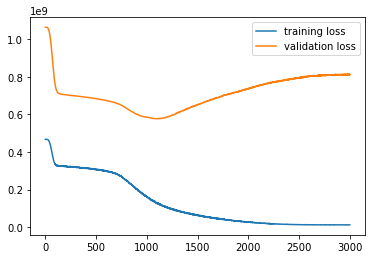

In [12]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,150))
plt.legend(['training loss','validation loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed'+str(seed)+'.jpg'))
plt.show()


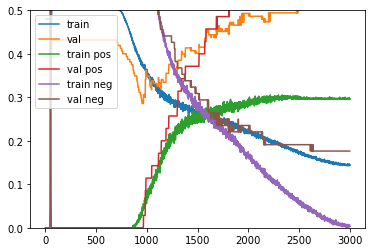

In [16]:
plt.plot(np.arange(epochs),train_lossclf_ep)
plt.plot(np.arange(epochs),val_lossclf_ep)
plt.plot(np.arange(epochs),train_lossclfPos_ep)
plt.plot(np.arange(epochs),val_lossclfPos_ep)
plt.plot(np.arange(epochs),train_lossclfNeg_ep)
plt.plot(np.arange(epochs),val_lossclfNeg_ep)

plt.ylim((0,0.5))
# plt.xlim((0,150))
plt.legend(['train','val','train pos','val pos','train neg','val neg'],loc='upper left')
plt.savefig(os.path.join(plotsavepath,'loss_clf_seed'+str(seed)+'_zoom.jpg'))
plt.show()


In [15]:
np.argmin(val_lossclfNeg_ep[100:])

1210

In [14]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(val_lossclfNeg_ep[500:])
# np.argmax(val_lossclfPos_ep[200:])
np.arange(3000)[np.less_equal(val_lossclfNeg_ep,val_lossclfPos_ep)][:200]
# nneg
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_ep[920]

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50, 1372, 1374, 1375, 1376,
       1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387,
       1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398,
       1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409,
       1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420,
       1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431,
       1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442,
       1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453,
       1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464,
       1465, 1466, 1467, 1468, 1469, 1470, 1471, 14

In [23]:
val_lossclfNeg_ep[1370]

tensor(0.3529, device='cuda:0')

In [14]:
def plotExprs(exprs,exprs2,savename,embedding,embedding2,savepath,savenameAdd='',norm=None):
#     fig, ax = plt.subplots(dpi=400)
    if not exprs is None:
        plt.scatter(embedding[:,0],embedding[:,1],s=5,c=exprs,cmap='Greys',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',norm=norm)
    plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=400)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [15]:
def plotExprsDiff(exprsPos,exprsNeg,exprs2,savename,embeddingPos,embeddingNeg,embedding2,savepath,savenameAdd='',norm=None):
#     fig, ax = plt.subplots(dpi=400)
    if not exprsPos is None:
        plt.scatter(embeddingPos[:,0],embeddingPos[:,1],s=5,c=exprsPos,cmap='Reds',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
        plt.scatter(embeddingNeg[:,0],embeddingNeg[:,1],s=5,c=exprsNeg,cmap=plt.cm.get_cmap('Blues'),edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=1200)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [12]:
# lossCE_binary=torch.nn.CrossEntropyLoss(reduction='none')
savenameAdd='_thresh1111'
# savenameAdd='_thresh4445'
lossThreshSize=1111
def plotLoss(inputNp,labelsNp,coordNp,name,savenameAdd=''):
    loss_test_all=np.zeros(inputNp.shape[0])
    loss_test_all_binary=np.zeros(inputNp.shape[0])
    loss_test_all_diff=np.zeros(inputNp.shape[0])
    pred_test_all=np.zeros(inputNp.shape[0])
    for i in range(inputNp.shape[0]):
        testInput=inputNp[[i]]
        labels=labelsNp[[i]]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        pred = model(testInput)
        loss_test_all[i]=lossCE(pred.flatten(),labels).item()
        pred_test_all[i]=pred.flatten()[0]
#         if pred[0]*labels[0]>0: 
        if labels[0]>0 and pred[0]>lossThreshSize:
            loss_test_all_binary[i]=0
#         elif pred[0]+labels[0]>0.001: #original
        elif pred[0]>lossThreshSize or labels[0]>0:
            loss_test_all_binary[i]=1
        else:
            loss_test_all_binary[i]=0
        loss_test_all_diff[i]=pred.flatten()[0]-labels[0]
        
    posidx=(labelsNp>0)
    negidx=labelsNp==0
    loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)
    loss_test_negLoss=np.sum(loss_test_all[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive: {:.4f}'.format(loss_test_posLoss),
         'loss negative: {:.4f}'.format(loss_test_negLoss))
    
    fig, ax = plt.subplots(dpi=400)
    fig.set_figheight(8)
    fig.set_figwidth(4)
    plt.xscale('log')
    plt.yscale('log')
#     print(labelsNp[posidx])
#     print(pred_test_all[posidx])
    plt.scatter(labelsNp[posidx],pred_test_all[posidx]+0.1)
    plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffscatter_positive'+'.jpg'))
    plt.close()
    
    largeridx=np.logical_and(posidx,loss_test_all_diff>=0)
    smalleridx=np.logical_and(posidx,loss_test_all_diff<0)
    if np.sum(largeridx)>0:
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.xscale('log')
        plt.hist(loss_test_all_diff[largeridx],bins=np.logspace(np.log10(np.min(loss_test_all_diff[largeridx])),np.log10(np.max(loss_test_all_diff[largeridx])),51))
#         plt.yscale('log')
        plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_positiveLarger'+'.jpg'))
        plt.close()
    if np.sum(smalleridx)>0:
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.xscale('log')
        plt.hist(np.abs(loss_test_all_diff[smalleridx]),bins=np.logspace(np.log10(np.min(np.abs(loss_test_all_diff[smalleridx]))),np.log10(np.max(np.abs(loss_test_all_diff[smalleridx]))),51))
        plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_positiveSmaller'+'.jpg'))
        plt.close()
    fig, ax = plt.subplots(dpi=400)
    fig.set_figheight(2.5)
    fig.set_figwidth(10)
    plt.xscale('log')
    plt.hist(loss_test_all_diff[negidx]+0.1,bins=np.logspace(np.log10(np.min(loss_test_all_diff[negidx]+0.1)),np.log10(np.max(loss_test_all_diff[negidx]+0.1)),51))
    plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_negative'+'.jpg'))
    plt.close()
    
#     plotExprs(loss_test_all[posidx],loss_test_all[negidx]+0.1,name+'loss'+s,coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#     if np.sum(posidx)>0:
#         plotExprs(loss_test_all[posidx],None,name+'loss'+s+'_positive',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#     plotExprs(None,loss_test_all[negidx]+0.1,name+'loss'+s+'_negative',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

#     if np.sum(posidx)>0:
#         plotExprsDiff(loss_test_all_diff[largeridx],np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff',coordNp[largeridx],coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(loss_test_all_diff[largeridx],np.abs(loss_test_all_diff[smalleridx]),None,name+'loss'+s+'_diff_positive',coordNp[largeridx],coordNp[smalleridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[largeridx],loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff2',coordNp[smalleridx],coordNp[largeridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[largeridx],None,name+'loss'+s+'_diff2_positive',coordNp[smalleridx],coordNp[largeridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

#     plotExprsDiff(None,None,loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff_negative',coordNp[largeridx],coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

    loss_test_posLoss_binary=np.sum(loss_test_all_binary[posidx])/np.sum(posidx)
    loss_test_negLoss_binary=np.sum(loss_test_all_binary[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive binary: {:.4f}'.format(loss_test_posLoss_binary),
         'loss negative binary: {:.4f}'.format(loss_test_negLoss_binary))
    
#     plotExprs(loss_test_all_binary[posidx],loss_test_all_binary[negidx],name+'loss'+s+'_binary',coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)
#     if np.sum(posidx)>0:
#         plotExprs(loss_test_all_binary[posidx],None,name+'loss'+s+'_positive'+'_binary',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd)
#     plotExprs(None,loss_test_all_binary[negidx],name+'loss'+s+'_negative'+'_binary',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)

    
testepoch=1250
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
plotepoch='epoch1250'
plotepoch+=savenameAdd
trainInput=allInputnp[alltrainIdx]
trainLabels=allLabelsnp[alltrainIdx]
testInput=allInputnp[alltestIdx]
testLabels=allLabelsnp[alltestIdx]
valInput=allInputnp[allvalIdx]
valLabels=allLabelsnp[allvalIdx]
for s in plot_samples.keys():
#     if s in training_samples:
#         continue
    print(s)
#     if s in ['disease13','disease8']:
#         imageslist_s=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,plaqueSizeFactor,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
#     if s in ['control13','control8']:
#         imageslist_s=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    
#     trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=imageslist_s
    if s in training_samples:
        sidx=(allSampleNames==s)
        testInputnp=testInput[sidx[alltestIdx]]
        testLabelsnp=testLabels[sidx[alltestIdx]]
        testCoordnp=None
        trainInputnp=trainInput[sidx[alltrainIdx]]
        trainLabelsnp=trainLabels[sidx[alltrainIdx]]
        trainCoordnp=None
        valInputnp=valInput[sidx[allvalIdx]]
        valLabelsnp=valLabels[sidx[allvalIdx]]
        valCoordnp=None

        plotLoss(testInputnp,testLabelsnp,testCoordnp,'test',plotepoch)
        plotLoss(trainInputnp,trainLabelsnp,trainCoordnp,'train',plotepoch)
        plotLoss(valInputnp,valLabelsnp,valCoordnp,'val',plotepoch)
    
    plotLoss(mulist[s],labellist[s],None,'all',plotepoch)
    
#     trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=None,None,None,None,None,None,None,None,None
#     imageslist_s=None

disease13
test results loss positive: 418073235.9889 loss negative: 535385974.6265
test results loss positive binary: 0.2444 loss negative binary: 0.7436
train results loss positive: 430467118.8328 loss negative: 454187344.3135
train results loss positive binary: 0.2745 loss negative binary: 0.7143
val results loss positive: 496510093.4524 loss negative: 688592319.3340
val results loss positive binary: 0.1429 loss negative binary: 0.8250
all results loss positive: 432176763.6556 loss negative: 476889211.6043
all results loss positive binary: 0.2660 loss negative binary: 0.7240
control13
test results loss positive: nan loss negative: 220383317.1747


/tmp/ipykernel_121755/750650370.py:31: RuntimeWarning: invalid value encountered in double_scalars
  loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)
/tmp/ipykernel_121755/750650370.py:88: RuntimeWarning: invalid value encountered in double_scalars
  loss_test_posLoss_binary=np.sum(loss_test_all_binary[posidx])/np.sum(posidx)


test results loss positive binary: nan loss negative binary: 0.3133
train results loss positive: nan loss negative: 164190755.5041
train results loss positive binary: nan loss negative binary: 0.3060
val results loss positive: nan loss negative: 279477318.3527
val results loss positive binary: nan loss negative binary: 0.3810
all results loss positive: nan loss negative: 174993048.9794
all results loss positive binary: nan loss negative binary: 0.3102
disease8
all results loss positive: 220060425.5442 loss negative: 213848839.2829
all results loss positive binary: 0.4481 loss negative binary: 0.5363
control8
all results loss positive: nan loss negative: 261584163.9099
all results loss positive binary: nan loss negative binary: 0.5555
